# Detecting and analyzing news events

Damian Trilling and Marieke van Hoof


This Notebook contains the analysis of the similarity files created with the INCA-functions to calculate cosine and soft-cosine similarities.

In [1]:
import os
from glob import glob
import json
from tqdm import tqdm
import leidenalg
import igraph as ig
import networkx as nx
import infomap
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.externals import joblib
from utilities import most_distinguishing_words
from string import punctuation
punctuation = punctuation+"‘–"
from nltk import ngrams
import requests
stopword_list = requests.get("https://raw.githubusercontent.com/stopwords-iso/stopwords-nl/master/stopwords-nl.txt").text.splitlines()
%matplotlib inline

## Load/specify datasets

We need to load three datasets:

1. Nodes and edges for the softcosine-dataset
2. As a baseline for comparisons: nodes and edges for the traditional cosine dataset
3. The articles themselves (titles, texts, ...) to join with the first two datasets

In [2]:
softcosinefiles = glob('../../data/intermediate/softcosine/*.net')
cosinefiles = glob('../../data/intermediate/cosine/*.net')

print('There are {} softcosine and {} cosine files.'.format(len(softcosinefiles), len(cosinefiles)))

There are 149 softcosine and 149 cosine files.


In [3]:
# There are essentially two ways of going about combining all our files
# Either we merge them first and create ONE graph that we partition later,
# or we partition each file's graph seperately.
# The theoretical implication is that in the first scenario, the three-day
# moving window can be stretched (as something on the last day of a window
# can also be similar to sth in the 'new' window), in the latter scenario,
# that's not possible. 
# Empirical tests show that this stretching can lead to a drift over time,
# with large partitions that extend to multiple events. 
# However, this problem only emerges when using an unsuitable clustering
# algorithm, in particular modularity (instead of surprise)

def merge_pajekfiles(files, outputfile):
    G = nx.Graph()
    for f in tqdm(files):
        H = nx.read_pajek(f)
        for node in H:         # remove all node properties, such as misleading/non-unique ids
            del H.node[node]['id']
            del H.node[node]['x']
            del H.node[node]['y']
            del H.node[node]['shape']
        G.update(H)
    print('{} nodes and {} edges'.format(len (G.nodes), len(G.edges)))
    print('Removing self loops...')
    G.remove_edges_from(list(G.selfloop_edges()))
    print('{} nodes and {} edges'.format(len (G.nodes), len(G.edges)))
    nx.write_pajek(G, outputfile)
    print('All written to {}'.format(outputfile))
    return G
Gnxsoft = merge_pajekfiles(softcosinefiles, '../../data/intermediate/softcosine_merged.net')
Gnxcos = merge_pajekfiles(cosinefiles, '../../data/intermediate/cosine_merged.net')
Gsoft = ig.read('../../data/intermediate/softcosine_merged.net', format='pajek')
Gcos = ig.read('../../data/intermediate/cosine_merged.net', format='pajek')


100%|██████████| 149/149 [02:50<00:00,  1.23it/s]


45608 nodes and 935592 edges
Removing self loops...
45608 nodes and 890597 edges


  0%|          | 0/149 [00:00<?, ?it/s]

All written to ../../data/intermediate/softcosine_merged.net


100%|██████████| 149/149 [00:34<00:00,  4.78it/s]


45213 nodes and 109336 edges
Removing self loops...
45213 nodes and 64341 edges
All written to ../../data/intermediate/cosine_merged.net


In [4]:
with open('../../data/raw-private/articles/articles_as_json-lines.json', mode='r') as f:
    articles = pd.DataFrame((json.loads(l) for l in f))
print(articles.keys())
print('{} articles in total'.format(len(articles)))

Index(['_id', 'byline', 'category', 'doctype', 'feedurl', 'images',
       'paywall_na', 'publication_date', 'softcosine_processed', 'teaser',
       'teaser_rss', 'text', 'title', 'title_rss', 'url'],
      dtype='object')
45609 articles in total


## Define functions
Here, we define functions to transform the files to a graph, partition the graph, analyze it, etc.

In [5]:
def partition_graph(G0, minedgeweight):
    '''takes an igraph, prunes it and particions it. returns a list of partitions '''
    G = G0.copy()
    G.es.select(weight_le=minedgeweight).delete()
    # part = leidenalg.find_partition(G, leidenalg.ModularityVertexPartition)
    part = leidenalg.find_partition(G, leidenalg.SurpriseVertexPartition)
    # print(part.summary())
    partitions = []
    for subgraph in part.subgraphs():
         partitions.append([node['id'] for node in subgraph.vs])
    return partitions

In [6]:
def show_descriptives(results, filename=None):
    '''takes a list of lists (articles per event), plots a histogram and prints descriptives'''
    articles_per_event = [len(x) for x in results]
    single_article_events = sum([1 if e==1 else 0 for e in articles_per_event])
    multiple_article_events = len(articles_per_event) - single_article_events
    fig = plt.figure(figsize=(10,5))
    plt.hist(articles_per_event, bins = max(articles_per_event), log=True)
    if filename:
        plt.savefig(filename+'.png', dpi=400)
        plt.savefig(filename+'.eps')
    plt.show()
    print(pd.Series(articles_per_event).describe())
    print('\nThere are {} single-article events and {} multiple-article events.'.format(
        single_article_events, multiple_article_events))

In [7]:
def print_gridreport(gridresults):
    for r in gridresults:
        l = r['results']
        flattened = [item for sublist in l for item in sublist]

        print('Found {} articles, out of which {} are unique articles'.format(len(flattened), len(set(flattened))))
    print('(hint: if *not* all articles are unique, then articles are assigned to multiple events)')
    print('\n\n')

    for r in gridresults:
        print("*"*80)
        print('Similarity metric: {}\n Minimum edgeweight: {}\n'.format(r['similarity'], r['minedgeweight']))
        print("*"*80)
        show_descriptives(r['results'], filename = '../../report/figures/{}{}'.format(r['similarity'], r['minedgeweight']))
        print('\n\n\n')

## Conduct clustering

We now conduct the clustering. We use a grid in which we vary the similarity calculation (cosine vs softcosine) and the minimum edgeweight threshold (.2, .3, .4, .5, .6)

In [8]:
grid = [('cos', Gcos, .2),
        ('cos', Gcos, .3),
        ('cos', Gcos, .4),
        ('cos', Gcos, .5),
        ('cos', Gcos, .6),
        ('softcos', Gsoft, .2),
        ('softcos', Gsoft, .3),
        ('softcos', Gsoft, .4),
        ('softcos', Gsoft, .5),
        ('softcos', Gsoft, .6)]

gridresults = [{'similarity':similarity, 'minedgeweight': minedgeweight, 'results': partition_graph(G, minedgeweight)} 
              for similarity, G, minedgeweight in tqdm(grid)]



100%|██████████| 10/10 [01:17<00:00,  7.09s/it]


Found 45213 articles, out of which 45213 are unique articles
Found 45213 articles, out of which 45213 are unique articles
Found 45213 articles, out of which 45213 are unique articles
Found 45213 articles, out of which 45213 are unique articles
Found 45213 articles, out of which 45213 are unique articles
Found 45608 articles, out of which 45608 are unique articles
Found 45608 articles, out of which 45608 are unique articles
Found 45608 articles, out of which 45608 are unique articles
Found 45608 articles, out of which 45608 are unique articles
Found 45608 articles, out of which 45608 are unique articles
(hint: if *not* all articles are unique, then articles are assigned to multiple events)



********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.2

********************************************************************************


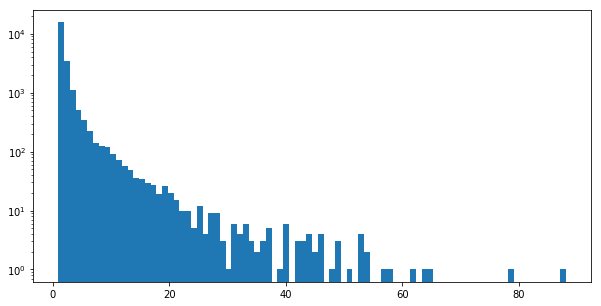

count    22312.000000
mean         2.026398
std          3.473195
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         88.000000
dtype: float64

There are 15630 single-article events and 6682 multiple-article events.




********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.3

********************************************************************************


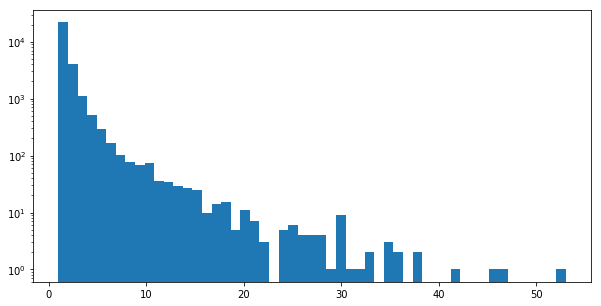

count    28635.000000
mean         1.578942
std          2.005513
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         53.000000
dtype: float64

There are 21856 single-article events and 6779 multiple-article events.




********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.4

********************************************************************************


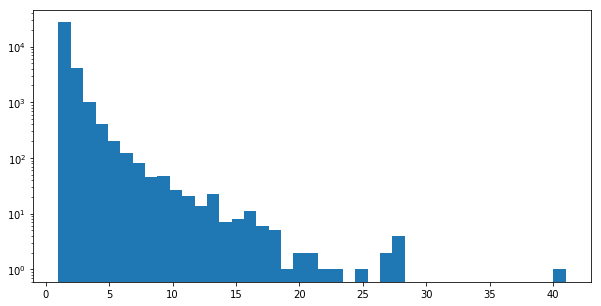

count    33378.000000
mean         1.354575
std          1.210611
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         41.000000
dtype: float64

There are 27136 single-article events and 6242 multiple-article events.




********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.5

********************************************************************************


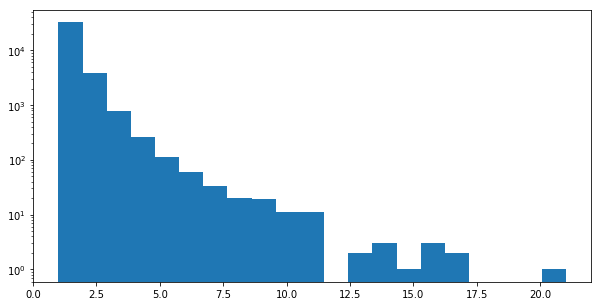

count    37397.000000
mean         1.209001
std          0.712653
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         21.000000
dtype: float64

There are 32232 single-article events and 5165 multiple-article events.




********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.6

********************************************************************************


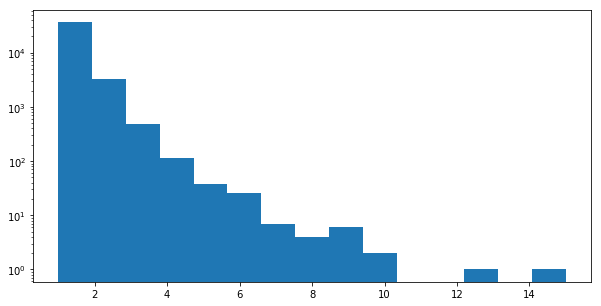

count    40247.000000
mean         1.123388
std          0.449985
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         15.000000
dtype: float64

There are 36348 single-article events and 3899 multiple-article events.




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.2

********************************************************************************


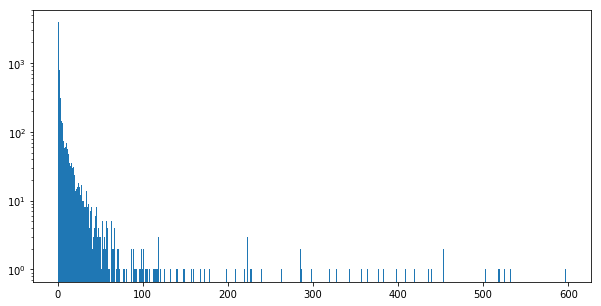

count    6401.000000
mean        7.125137
std        30.599078
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       597.000000
dtype: float64

There are 3918 single-article events and 2483 multiple-article events.




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.3

********************************************************************************


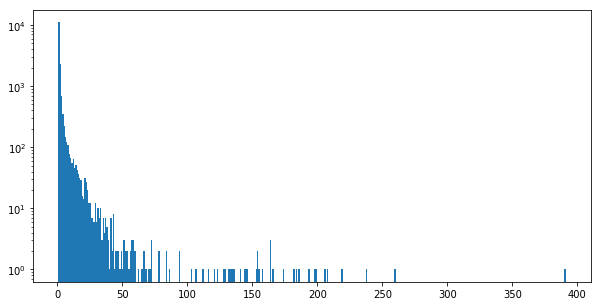

count    15789.000000
mean         2.888593
std         10.121378
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        391.000000
dtype: float64

There are 11037 single-article events and 4752 multiple-article events.




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.4

********************************************************************************


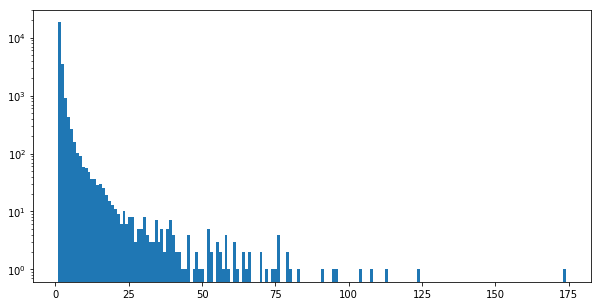

count    24295.000000
mean         1.877259
std          4.319026
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        174.000000
dtype: float64

There are 18335 single-article events and 5960 multiple-article events.




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.5

********************************************************************************


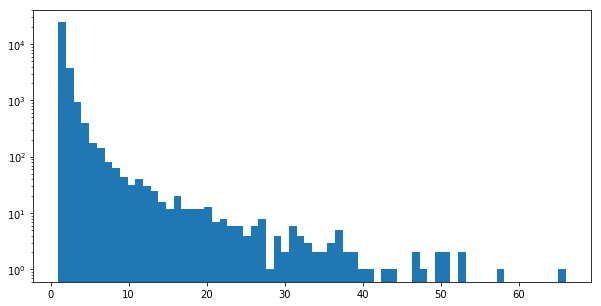

count    30271.000000
mean         1.506657
std          2.262406
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         66.000000
dtype: float64

There are 24325 single-article events and 5946 multiple-article events.




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.6

********************************************************************************


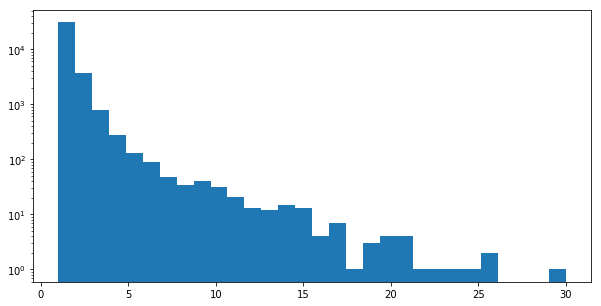

count    35958.000000
mean         1.268369
std          1.070040
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         30.000000
dtype: float64

There are 30700 single-article events and 5258 multiple-article events.






In [9]:
print_gridreport(gridresults)

## Evaluation of the results

check how much sense it makes etc

In [10]:
def merge_results_with_articles(results):
    results_merged = [[articles.query('_id=="{}"'.format(art)) for art in event] for event in results]
    df = pd.DataFrame(results_merged)
    return df

def _getfield(x, field):
    try:
        return x[field].to_list()[0]
    except:
        return None
def reduce_to_field(merged_df, field):
    return merged_df.applymap(lambda x: _getfield(x, field))

In [11]:
df_cos04 = merge_results_with_articles(gridresults[2]['results'])
df_cos05 = merge_results_with_articles(gridresults[3]['results'])
df_cos06 = merge_results_with_articles(gridresults[4]['results'])
df_softcos04 = merge_results_with_articles(gridresults[7]['results'])
df_softcos05 = merge_results_with_articles(gridresults[8]['results'])
df_softcos06 = merge_results_with_articles(gridresults[9]['results'])

### Manual evaluation of method
To evaluate the cosine and softcosine simiarlity methods on precision, we manually inspect a random sample of 100 multiple-article news events for minedgeweight=0.4, 0.5 and 0.6. Precision is defined as the number of articles  in the cluster that relate to the news event relative to the total number of articles in the cluster. The files can be found in ../../data/evaluation.

#### Create random samples

In [12]:
outdir = '../../data/evaluation'
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [13]:
df_list = [df_cos04, df_cos05, df_cos06, df_softcos04, df_softcos05, df_softcos06]
names = ['cos04', 'cos05', 'cos06', 'softcos04', 'softcos05', 'softcos06']

In [14]:
i = 101
for name, data in zip(names, df_list):
    df = reduce_to_field(data, 'title')
    n_articles = df.count(axis=1)
    df = df.join(n_articles.rename('n_articles'))
    df = df.loc[df.n_articles > 1] # reducde to multi-article news events
    df.replace(',' '', inplace=True)
    df = df.sample(n=100, random_state=i)
    filename = '{name}_EMPTY.csv'.format(name=name)
    df.to_csv(os.path.join(outdir, filename), sep=',')
    print('Random sample for', name, 'with random_state =', i, 'saved as ../../data/evaluation/{name}_EMPTY.csv'.format(name=name))
    i += 1

Random sample for cos04 with random_state = 101 saved as ../../data/evaluation/cos04_EMPTY.csv
Random sample for cos05 with random_state = 102 saved as ../../data/evaluation/cos05_EMPTY.csv
Random sample for cos06 with random_state = 103 saved as ../../data/evaluation/cos06_EMPTY.csv
Random sample for softcos04 with random_state = 104 saved as ../../data/evaluation/softcos04_EMPTY.csv
Random sample for softcos05 with random_state = 105 saved as ../../data/evaluation/softcos05_EMPTY.csv
Random sample for softcos06 with random_state = 106 saved as ../../data/evaluation/softcos06_EMPTY.csv


#### Calculate precision

Precision is presented in three ways:
 - __Prec. 1:__ Percentage of news events that are entirely correct.
 - __Prec. 2:__ Percentage of news articles that relate to the news events correctly.
 - __TP/max. TP:__ True Positives out of the maximum True Postives.

In [15]:
eval_list = []
for name in names:
    eval_list.append(pd.read_csv('../../data/evaluation/{}_DONE.csv'.format(name), sep=';'))

In [16]:
def calculate_precision(df):
    df['precision'] = np.where(df.n_articles == df.n_correct, 1, 0)
    score_opt1 = (df['precision'].value_counts()[1] / len(df)) * 100
    df['proportion_correct'] = (df.n_correct / df.n_articles) * 100
    score_opt2 = df.proportion_correct.mean()
    score_opt3 = sum(df.n_correct)
    total_articles = sum(df.n_articles)
    print('Perc. 1:', score_opt1, '\nPrec. 2:', score_opt2, '\nTP/max. TP:', score_opt3, '/', total_articles)

In [17]:
precision_df = pd.DataFrame()
for name, df in zip(names, eval_list):
    print('Results for...', name)
    calculate_precision(df)

Results for... cos04
Perc. 1: 74.0 
Prec. 2: 88.51709401709401 
TP/max. TP: 223 / 268
Results for... cos05
Perc. 1: 78.0 
Prec. 2: 89.01666666666667 
TP/max. TP: 217 / 253
Results for... cos06
Perc. 1: 89.0 
Prec. 2: 94.38690476190476 
TP/max. TP: 204 / 225
Results for... softcos04
Perc. 1: 56.00000000000001 
Prec. 2: 76.2042970917971 
TP/max. TP: 234 / 521
Results for... softcos05
Perc. 1: 65.0 
Prec. 2: 81.7704939668175 
TP/max. TP: 236 / 379
Results for... softcos06
Perc. 1: 75.0 
Prec. 2: 86.91932234432235 
TP/max. TP: 222 / 289


### RQ1

In [18]:
def get_venn_from_outlets(outlet_df, filename=None):
    outlets_per_event = outlet_df.apply(lambda x: x.value_counts(), axis=1).fillna(0)
    dichotomized = outlets_per_event.applymap(lambda x: x > 0)
    events_ad = set(dichotomized[dichotomized['ad (www)']==True].index)
    events_vk = set(dichotomized[dichotomized['volkskrant (www)']==True].index)
    events_nu = set(dichotomized[dichotomized['nu']==True].index)
    fig = plt.figure(figsize=(10,10))
    venn3([events_ad, events_vk, events_nu], set_labels = ['AD', 'Volkskrant', 'nu'])
    if filename:
        plt.savefig(filename+'.png', dpi=400)
        plt.savefig(filename+'.eps')
    plt.show()

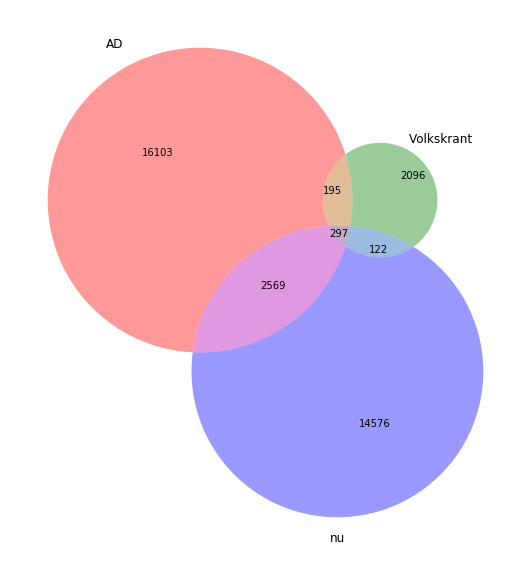

In [19]:
df_softcos06_outlet = reduce_to_field(df_softcos06, 'doctype')
get_venn_from_outlets(df_softcos06_outlet, '../../report/figures/vennsoft06')

### RQ2

To compare the content of fully covered news events with AD-only, Volkskrant-only and nu.nl-only news events, we apply an automated method that classifies Dutch news items into four news categories: Politics, Business, Entertainment and Other ([Vermeer, 2018](https://figshare.com/articles/A_supervised_machine_learning_method_to_classify_Dutch-language_news_items/7314896/1)).

In [20]:
def get_fully_covered_events(outlet_df):
    outlets_per_event = outlet_df.apply(lambda x: x.value_counts(), axis=1).fillna(0)
    dichotomized = outlets_per_event.applymap(lambda x: x > 0)
    
    events_fullycovered = set(dichotomized[dichotomized.sum(axis=1)==3].index)
    ad_only = set(dichotomized[(dichotomized['ad (www)'] == 1) & (dichotomized['nu'] == 0) & (dichotomized['volkskrant (www)'] == 0)].index)
    vk_only = set(dichotomized[(dichotomized['ad (www)'] == 0) & (dichotomized['nu'] == 0) & (dichotomized['volkskrant (www)'] == 1)].index)
    nu_only = set(dichotomized[(dichotomized['ad (www)'] == 0) & (dichotomized['nu'] == 1) & (dichotomized['volkskrant (www)'] == 0)].index)
    
    groups = (events_fullycovered, ad_only, vk_only, nu_only)
    
    return groups

def get_topics(text_df, path_to_model):
    clf = joblib.load(path_to_model)
    i=0
    all_text = text_df.values.tolist()
    no_none = []
    for l in all_text:
        for text in l:
            if text == None:
                i+=1
            elif text != None:
                # make lowercase and remove punctuation and stopwords.
                text = text.lower().translate(str.maketrans('', '', punctuation)).split()
                filtered_text = []
                for word in text:
                    if word not in stopword_list:
                        filtered_text.append(word)
                no_none.append(" ".join(filtered_text))
    
    topic = clf.predict([e for e in no_none])
    unique, counts = np.unique(topic, return_counts=True)
    result = dict(zip(unique, counts/len(topic)*100))
    
    return result

def topic_graph(topics):
    labels = ['Fully covered', 'AD only', 'VK only', 'nu.nl only']
    barWidth = 0.23

    plt.figure(figsize=(10,5))

    r1 = np.arange(len(topics['Business']))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]

    plt.bar(r1, topics['Business'], width=barWidth, label='Business')
    plt.bar(r2, topics['Entertainment'], width=barWidth, label='Entertainment')
    plt.bar(r3, topics['Politics'], width=barWidth, label='Politics')
    plt.bar(r4, topics['Other'], width=barWidth, label='Other')

    plt.xlabel('')
    plt.xticks([r + barWidth for r in range(len(topic_fully))], labels)

    plt.legend()
    filename = '../../report/figures/classification'
    plt.savefig(filename+'.png', dpi=400)
    plt.savefig(filename+'.eps')
    plt.show()

In [21]:
# Download classifier by Vermeer (2018) if we don't have it yet

PATH_TO_MODEL = '../lib/PassiveAggressive_text_Dutch_news.pkl'

if not os.path.exists(PATH_TO_MODEL):
    r = requests.get('https://ndownloader.figshare.com/files/13514468', allow_redirects=True)
    with open(PATH_TO_MODEL, mode = 'wb') as f:
        f.write(r.content)
    print('Downloaded classifier with status code {} and saved as {}'.format(r.status_code, PATH_TO_MODEL))

In [22]:
df_softcos06_outlet = reduce_to_field(df_softcos06, 'doctype')
groups = get_fully_covered_events(df_softcos06_outlet)

In [23]:
df_softcos06_text = reduce_to_field(df_softcos06, 'text')

In [24]:
fully_text = df_softcos06_text.iloc[list(groups[0])]
ad_text = df_softcos06_text.iloc[list(groups[1])]
vk_text = df_softcos06_text.iloc[list(groups[2])]
nu_text = df_softcos06_text.iloc[list(groups[3])]

In [25]:
topic_fully = get_topics(fully_text, PATH_TO_MODEL)
topic_ad = get_topics(ad_text, PATH_TO_MODEL)
topic_vk = get_topics(vk_text, PATH_TO_MODEL)
topic_nu = get_topics(nu_text, PATH_TO_MODEL)

In [26]:
topics = pd.DataFrame([topic_fully, topic_ad, topic_vk, topic_nu])
topics

,Business,Entertainment,N/A,Other,Politics
0,18.746503,41.074426,NaN,9.121433,31.057639
1,12.310848,78.920237,0.016629,2.361288,6.390998
2,22.191142,37.435897,0.046620,3.496503,36.829837
3,18.516104,71.560829,0.032599,3.279437,6.611031


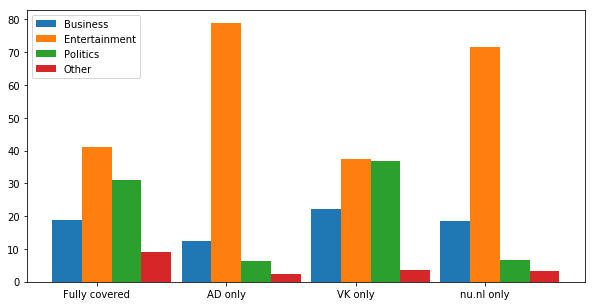

In [27]:
topic_graph(topics=topics)

In [28]:
def column_to_words(df, bigrams = True):
    '''we are only considering the first article; we only want one per event b/c we 
    are interested in the events not the articles'''
    longstring = df[0].str.cat()
    longstring = longstring.translate(str.maketrans('', '', punctuation))
    tokens = [w.lower() for w in longstring.split()]
    filtered_tokens=[]
    for word in tokens:
        if word not in stopword_list:
            filtered_tokens.append(word)
    if bigrams:
        filtered_tokens.extend(["_".join(tup).lower() for tup in ngrams(longstring.split(),2)])
    return filtered_tokens

### ad vs fully covered
it's sports

In [29]:
md_ad = most_distinguishing_words(column_to_words(ad_text), column_to_words(fully_text), top = 20)
md_ad

,loglikelihood,word,observed corpus 1,expected corpus 1,observed corpus 2,expected corpus 2
0,82.285596,seizoen,2041,1983.8992086844405,8,65.10079131555955
1,67.078467,auto,2038,1984.867436702344,12,65.13256329765596
2,59.854001,punten,1423,1382.6296095663158,5,45.37039043368425
3,56.596026,finale,1015,983.7196661900398,1,32.28033380996022
4,40.754149,wedstrijd,1345,1310.9807362414506,9,43.01926375854935
5,39.283825,wk,737,714.5522772128438,1,23.447722787156145
6,37.836459,ploeg,962,935.3082652948607,4,30.691734705139343
7,37.747194,nummer,1098,1068.923731765555,6,35.07626823444497
8,37.297483,club,1451,1416.517590192941,12,46.482409807058865
9,37.120930,dit_seizoen,702,680.6642965862185,1,22.33570341378153


In [30]:
with open('../../report/table_appendix_loglikelihood_ad.tex', mode='w') as f:
    f.write(md_ad.to_latex())

### nu vs fully covered
it's sports and entertainment and crime

In [31]:
md_nu = most_distinguishing_words(column_to_words(nu_text), column_to_words(fully_text), top = 20)
md_nu

,loglikelihood,word,observed corpus 1,expected corpus 1,observed corpus 2,expected corpus 2
0,110.350688,uur,4751,4635.4757273190135,54,169.5242726809863
1,81.167876,auto,2068,2006.6159235845055,12,73.38407641549458
2,78.927624,seizoen,1781,1725.8826381214808,8,63.11736187851914
3,75.270898,the,2466,2399.2566355551276,21,87.74336444487261
4,75.187777,film,1516,1467.3378941211695,5,53.66210587883042
5,69.090713,politie,5613,5508.546597917079,97,201.45340208292023
6,63.862579,uur_op,889,857.6353634935699,0,31.364636506430138
7,63.122136,nunl,1398,1354.4657484195411,6,49.53425158045884
8,54.317433,aangehouden,1321,1281.1470896731842,7,46.852910326815774
9,49.998149,festival,696,671.4445590455845,0,24.555440954415495


In [32]:
with open('../../report/table_appendix_loglikelihood_nu.tex', mode='w') as f:
    f.write(md_nu.to_latex())

### vk vs fully covered
it's politics!

In [33]:
md_vk = most_distinguishing_words(column_to_words(vk_text), column_to_words(fully_text), top = 20)
md_vk

,loglikelihood,word,observed corpus 1,expected corpus 1,observed corpus 2,expected corpus 2
0,25.869075,zegt,3831,3750.5041023396448,216,296.49589766035507
1,23.060012,auto’s,200,186.27411034600163,1,14.72588965399836
2,22.673511,hesjes,149,138.0837932415634,0,10.916206758436596
3,22.217285,hoogleraar,286,268.7536915439825,4,21.246308456017534
4,21.656240,politieke,905,871.1326553494604,35,68.8673446505396
5,21.640624,huizen,190,177.0067416720712,1,13.99325832792879
6,21.303970,gele_hesjes,140,129.74316143502602,0,10.256838564973982
7,20.443092,gele,215,201.10190022429032,2,15.898099775709673
8,19.240663,nieuwsbrief,173,161.25221492638948,1,12.74778507361052
9,18.177646,zorg,302,285.43495515705723,6,22.56504484294276


In [34]:
with open('../../report/table_appendix_loglikelihood_vk.tex', mode='w') as f:
    f.write(md_vk.to_latex())

# Compare with infomap

infomap was used by Nicholls2018. It does not require a threshold (they say)

In [35]:
def findCommunities(Gin, minedgeweight=None):
    """
    Partition network with the Infomap algorithm.
    Annotates nodes with 'community' id and return number of communities found.
    """
    
    G = Gin.copy()
    
    if minedgeweight:
        insignificant_edges = ([(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] < minedgeweight])
        G.remove_edges_from(insignificant_edges)

    infomapWrapper = infomap.Infomap("--two-level --silent")  # even testen zonder two-level
    # infomapWrapper = infomap.Infomap(" --silent")
    
    network = infomapWrapper.network()

    print("Building Infomap network from a NetworkX graph...")
    for e in G.edges(data=True):
        network.addLink(e[0],e[1],e[2]['weight'])

    print("Find communities with Infomap...")
    infomapWrapper.run();

    #tree = network.tree

    # print("Found %d modules with codelength: %f" % (tree.numTopModules(), tree.codelength()))

    print("Found {} modules with codelength: {}".format(infomapWrapper.numTopModules(), infomapWrapper.codelength()))

    print("Result")
    print("\n#node module")
 
    communities = {}
    for node in infomapWrapper.iterTree():
        if node.isLeaf():
            print("{} {}".format(node.physicalId, node.moduleIndex()))
    
        communities[node.physicalId] = node.moduleIndex()

    nx.set_node_attributes(G, name='community', values=communities)
    return G

In [36]:
Gnxint = nx.convert_node_labels_to_integers(Gnxcos)
H = findCommunities(Gnxint)


Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 6630 modules with codelength: 3.983389471894859
Result

#node module
0 0
18247 0
1 1
8736 1
44550 1
3 2
19193 2
5 3
5372 3
10261 3
12270 3
12308 3
25861 3
31546 3
35321 3
37094 3
37877 3
39248 3
39673 3
44986 3
6 4
18114 4
36850 4
8 5
2764 5
4255 5
23079 5
27803 5
33513 5
9 6
213 6
828 6
1611 6
1754 6
4299 6
4410 6
4668 6
5879 6
8594 6
9078 6
9707 6
9907 6
11957 6
13409 6
14926 6
15049 6
15099 6
15108 6
15726 6
15793 6
19576 6
20666 6
20868 6
20884 6
21237 6
21612 6
21821 6
21963 6
22379 6
24102 6
24541 6
24827 6
26207 6
27330 6
27680 6
27778 6
28295 6
30958 6
31646 6
31651 6
33498 6
34960 6
36685 6
37731 6
38002 6
39386 6
39958 6
40640 6
40732 6
41689 6
42523 6
10 7
5749 7
25626 7
44905 7
11 8
2504 8
2808 8
3113 8
3320 8
7256 8
9199 8
9482 8
11094 8
13407 8
15680 8
19402 8
21975 8
22989 8
25767 8
26415 8
27789 8
30922 8
32668 8
32909 8
34452 8
38317 8
41301 8
43047 8
43284 8
12 9
1243 9
5901 9
633

9201 176
9814 176
10240 176
13809 176
17313 176
27547 176
27719 176
33074 176
34002 176
283 177
6680 177
7705 177
10957 177
14762 177
18166 177
22964 177
30587 177
31779 177
38973 177
39690 177
284 178
8762 178
18471 178
23623 178
38009 178
285 179
562 179
1713 179
1856 179
3407 179
4214 179
4744 179
4777 179
5035 179
7596 179
7762 179
8016 179
12409 179
12943 179
13369 179
17766 179
20270 179
21733 179
21775 179
23870 179
27285 179
29009 179
29091 179
29290 179
36053 179
36483 179
37800 179
38166 179
39995 179
41149 179
43323 179
43699 179
286 180
16458 180
290 181
16453 181
38478 181
42138 181
291 182
35721 182
292 183
8673 183
11720 183
34204 183
34580 183
293 184
1903 184
7828 184
11617 184
12630 184
16716 184
16928 184
20485 184
20568 184
20850 184
22056 184
23793 184
23966 184
28281 184
31202 184
31675 184
31803 184
35814 184
41110 184
43090 184
43797 184
295 185
2115 185
9508 185
18954 185
22921 185
25997 185
41664 185
44506 185
297 186
561 186
3016 186
6318 186
11689 186
26629 

42804 301
476 302
1267 302
8723 302
9502 302
13846 302
17136 302
27998 302
35909 302
42570 302
44345 302
478 303
7361 303
7452 303
7690 303
17649 303
27576 303
33204 303
39773 303
479 304
42726 304
481 305
43342 305
482 306
745 306
2036 306
2255 306
2894 306
3072 306
4913 306
5472 306
6497 306
6709 306
10253 306
10445 306
13103 306
13269 306
13827 306
14321 306
16096 306
17141 306
18039 306
18999 306
19438 306
20780 306
20782 306
21073 306
22781 306
22824 306
22882 306
22972 306
23171 306
24348 306
24839 306
25337 306
26737 306
28171 306
28938 306
29012 306
29689 306
30906 306
31059 306
31132 306
31542 306
31550 306
33979 306
35645 306
35999 306
36414 306
36453 306
37258 306
37415 306
38109 306
38979 306
39310 306
39704 306
40086 306
41182 306
42017 306
483 307
15961 307
28794 307
36451 307
484 308
25860 308
487 309
12545 309
488 310
1460 310
1669 310
2379 310
2703 310
3295 310
3585 310
4746 310
5082 310
8460 310
8998 310
9941 310
10359 310
10590 310
13348 310
16070 310
16856 310
17926

44165 485
808 486
31914 486
810 487
6513 487
6703 487
16479 487
18253 487
18695 487
23702 487
27324 487
28220 487
31429 487
33908 487
36100 487
43181 487
43242 487
813 488
6926 488
24055 488
36983 488
815 489
1058 489
2204 489
2584 489
3316 489
3519 489
3970 489
4587 489
7876 489
9040 489
20891 489
22814 489
26373 489
27817 489
30061 489
30932 489
31281 489
31630 489
34786 489
34917 489
37497 489
37558 489
37733 489
37942 489
38737 489
40219 489
41980 489
43708 489
816 490
3120 490
30680 490
817 491
1464 491
1896 491
9564 491
818 492
900 492
820 493
4924 493
7334 493
7868 493
8006 493
8447 493
10262 493
11973 493
13664 493
13751 493
16959 493
18852 493
21153 493
24697 493
29641 493
40888 493
821 494
9824 494
38191 494
823 495
3874 495
13695 495
25322 495
827 496
16045 496
829 497
12762 497
14088 497
15866 497
830 498
32446 498
832 499
39807 499
835 500
3848 500
4345 500
14421 500
23295 500
23698 500
24439 500
31233 500
42758 500
836 501
25852 501
837 502
38486 502
838 503
1780 503
840 

43936 797
1426 798
9537 798
23708 798
1427 799
10868 799
28435 799
1428 800
2087 800
2652 800
4660 800
4882 800
5543 800
5983 800
10247 800
12647 800
12942 800
13148 800
13644 800
13810 800
14858 800
14928 800
17068 800
18324 800
19934 800
20541 800
21613 800
23994 800
25224 800
28541 800
29707 800
30919 800
38584 800
44097 800
1429 801
18063 801
30190 801
36894 801
1431 802
3607 802
4377 802
5304 802
8430 802
8792 802
8798 802
9309 802
11438 802
11628 802
13041 802
13959 802
19415 802
19968 802
20532 802
21484 802
22078 802
26013 802
26554 802
27529 802
30997 802
31119 802
32575 802
34542 802
35841 802
37885 802
38100 802
38731 802
39032 802
39146 802
40598 802
40885 802
40963 802
42468 802
1433 803
4007 803
7777 803
9274 803
15224 803
15576 803
15664 803
16216 803
16600 803
20817 803
21428 803
22228 803
27276 803
30347 803
34056 803
41427 803
43726 803
43779 803
1437 804
25867 804
28160 804
29361 804
32128 804
1441 805
3273 805
3401 805
4802 805
6917 805
9400 805
11049 805
12156 805


12636 1009
31033 1009
33136 1009
38811 1009
1863 1010
6992 1010
41852 1010
1865 1011
2560 1011
19731 1011
29607 1011
32760 1011
38822 1011
43838 1011
1867 1012
3018 1012
22950 1012
27106 1012
37911 1012
1870 1013
22120 1013
1872 1014
16192 1014
36147 1014
1873 1015
3317 1015
36037 1015
39716 1015
1875 1016
30406 1016
41192 1016
1879 1017
28464 1017
1881 1018
2707 1018
2883 1018
3517 1018
3852 1018
4408 1018
4449 1018
5768 1018
5805 1018
8836 1018
9181 1018
10074 1018
13505 1018
15140 1018
15583 1018
16577 1018
17992 1018
18216 1018
18734 1018
18783 1018
19216 1018
20357 1018
22385 1018
22539 1018
23607 1018
23782 1018
24040 1018
25253 1018
25566 1018
27118 1018
27651 1018
29219 1018
29429 1018
29503 1018
29667 1018
30183 1018
36230 1018
39770 1018
39858 1018
40823 1018
41647 1018
42441 1018
43944 1018
44034 1018
1883 1019
25361 1019
1885 1020
10507 1020
30131 1020
1887 1021
31318 1021
1891 1022
3015 1022
4288 1022
6568 1022
6893 1022
12548 1022
32149 1022
34059 1022
35005 1022
40921 10

2542 1305
3775 1305
5453 1305
6367 1305
7501 1305
44196 1305
2544 1306
3557 1306
4353 1306
5336 1306
7237 1306
23188 1306
24089 1306
28675 1306
36340 1306
2547 1307
3135 1307
2548 1308
16885 1308
2550 1309
44110 1309
2551 1310
8552 1310
24112 1310
43768 1310
44455 1310
2552 1311
3791 1311
44493 1311
2553 1312
10476 1312
12122 1312
18155 1312
39291 1312
2561 1313
26180 1313
2569 1314
6798 1314
7192 1314
10989 1314
12118 1314
13450 1314
15745 1314
17463 1314
18195 1314
18369 1314
20053 1314
21372 1314
24233 1314
27331 1314
30960 1314
2570 1315
28500 1315
2571 1316
18997 1316
36297 1316
2572 1317
3889 1317
9620 1317
23268 1317
40497 1317
2573 1318
2713 1318
7163 1318
9346 1318
9761 1318
10683 1318
15761 1318
21227 1318
22086 1318
30580 1318
35861 1318
41997 1318
43472 1318
2575 1319
2692 1319
6756 1319
8225 1319
14815 1319
21854 1319
23493 1319
23507 1319
23553 1319
29229 1319
32971 1319
34384 1319
34630 1319
34696 1319
35273 1319
37572 1319
38455 1319
38787 1319
43039 1319
43791 1319
438

37639 1681
3449 1682
34052 1682
3451 1683
11188 1683
15938 1683
29126 1683
3453 1684
29568 1684
3457 1685
31437 1685
3459 1686
4565 1686
34846 1686
3462 1687
30219 1687
3464 1688
27149 1688
3470 1689
28985 1689
3472 1690
31294 1690
3473 1691
5643 1691
6256 1691
10364 1691
12159 1691
14939 1691
16311 1691
19482 1691
29387 1691
34211 1691
36325 1691
37350 1691
39740 1691
43028 1691
43228 1691
3474 1692
21849 1692
3477 1693
6458 1693
9504 1693
15957 1693
24174 1693
24797 1693
27608 1693
30666 1693
37748 1693
38141 1693
39165 1693
3479 1694
24454 1694
25781 1694
38523 1694
3481 1695
6646 1695
14282 1695
30214 1695
30510 1695
30890 1695
39335 1695
3484 1696
12315 1696
31898 1696
3489 1697
5196 1697
5978 1697
3493 1698
30627 1698
39365 1698
3494 1699
15585 1699
27453 1699
43244 1699
3495 1700
15596 1700
3497 1701
44654 1701
3502 1702
5014 1702
5401 1702
5853 1702
8539 1702
10191 1702
12310 1702
13781 1702
15665 1702
18263 1702
22634 1702
28006 1702
28140 1702
33337 1702
36922 1702
38732 1702

6688 2096
7160 2096
9068 2096
10053 2096
12783 2096
28624 2096
31968 2096
34510 2096
37334 2096
40551 2096
41201 2096
44740 2096
4572 2097
6771 2097
10747 2097
4574 2098
15252 2098
30801 2098
4575 2099
8105 2099
10970 2099
12241 2099
15113 2099
19648 2099
22419 2099
25452 2099
30760 2099
33821 2099
34093 2099
35160 2099
35338 2099
37712 2099
40658 2099
41283 2099
42406 2099
4578 2100
13287 2100
4580 2101
21370 2101
41091 2101
4581 2102
9655 2102
9756 2102
9892 2102
41567 2102
4585 2103
4787 2103
10956 2103
12624 2103
18140 2103
27742 2103
30792 2103
32901 2103
43612 2103
45165 2103
4590 2104
11661 2104
14284 2104
17524 2104
19223 2104
21753 2104
24560 2104
28524 2104
41232 2104
41435 2104
42742 2104
43647 2104
4593 2105
5550 2105
43353 2105
4594 2106
8477 2106
22513 2106
32147 2106
4597 2107
5385 2107
34936 2107
4598 2108
41424 2108
4599 2109
6298 2109
17854 2109
29800 2109
38770 2109
39047 2109
44809 2109
4600 2110
30169 2110
4601 2111
12920 2111
4605 2112
41532 2112
4609 2113
6955 21

15956 2494
16751 2494
25111 2494
31529 2494
32856 2494
33713 2494
37112 2494
42428 2494
5742 2495
26586 2495
29732 2495
32585 2495
34869 2495
44666 2495
5743 2496
31476 2496
5751 2497
6101 2497
5753 2498
6130 2498
20880 2498
35838 2498
43052 2498
43885 2498
5755 2499
28239 2499
5756 2500
22260 2500
5758 2501
20075 2501
22832 2501
24890 2501
36211 2501
5764 2502
13872 2502
5771 2503
12420 2503
5775 2504
14555 2504
5782 2505
33492 2505
5783 2506
11225 2506
32460 2506
42311 2506
5784 2507
27986 2507
5785 2508
26551 2508
5786 2509
20645 2509
5789 2510
22380 2510
27577 2510
5794 2511
7005 2511
12408 2511
40472 2511
40553 2511
5795 2512
9628 2512
30634 2512
5796 2513
39578 2513
5797 2514
44425 2514
5798 2515
36563 2515
5799 2516
26457 2516
42187 2516
5801 2517
15345 2517
5814 2518
15256 2518
40383 2518
5818 2519
8363 2519
8511 2519
8641 2519
22148 2519
30782 2519
36081 2519
38874 2519
41393 2519
43630 2519
5820 2520
11917 2520
16450 2520
18969 2520
21826 2520
22773 2520
31117 2520
31118 2520

33626 3085
7841 3086
15104 3086
7849 3087
9344 3087
11004 3087
12478 3087
16031 3087
17367 3087
18145 3087
18556 3087
27740 3087
38099 3087
39294 3087
39774 3087
7852 3088
13098 3088
19947 3088
24695 3088
7853 3089
19039 3089
7857 3090
21528 3090
25595 3090
42761 3090
7865 3091
16161 3091
7883 3092
29677 3092
7888 3093
13568 3093
34613 3093
7891 3094
38803 3094
7895 3095
20877 3095
7900 3096
27022 3096
29096 3096
7902 3097
30419 3097
7907 3098
13384 3098
7908 3099
18156 3099
19070 3099
21175 3099
25553 3099
32711 3099
7910 3100
25372 3100
7913 3101
20739 3101
37307 3101
7918 3102
32991 3102
7919 3103
25083 3103
7920 3104
8272 3104
12243 3104
13182 3104
20169 3104
20242 3104
21348 3104
22246 3104
37351 3104
39839 3104
44071 3104
7923 3105
27158 3105
7924 3106
10911 3106
33129 3106
7928 3107
13160 3107
26099 3107
7930 3108
22508 3108
43137 3108
44937 3108
7934 3109
30920 3109
7943 3110
19084 3110
22609 3110
24477 3110
25061 3110
31776 3110
37924 3110
40730 3110
41116 3110
7956 3111
21391

37302 3520
9533 3521
37379 3521
40482 3521
9534 3522
39160 3522
9538 3523
13336 3523
18698 3523
25021 3523
38511 3523
9540 3524
38903 3524
9541 3525
13059 3525
9547 3526
16678 3526
18789 3526
26577 3526
41176 3526
43789 3526
9562 3527
28014 3527
9565 3528
32626 3528
9567 3529
28730 3529
9571 3530
12196 3530
13723 3530
14044 3530
9576 3531
14678 3531
33633 3531
9578 3532
29445 3532
9583 3533
18546 3533
9585 3534
25691 3534
9595 3535
14140 3535
23887 3535
23936 3535
33154 3535
45051 3535
9599 3536
25113 3536
9607 3537
34413 3537
9611 3538
13429 3538
9613 3539
12852 3539
17387 3539
9616 3540
25473 3540
9619 3541
11965 3541
9622 3542
11693 3542
30708 3542
9630 3543
10173 3543
15154 3543
20295 3543
23170 3543
26449 3543
32423 3543
36861 3543
37625 3543
9633 3544
30011 3544
9636 3545
12452 3545
39509 3545
42541 3545
9641 3546
23309 3546
9642 3547
14714 3547
15582 3547
16062 3547
29436 3547
35190 3547
44065 3547
9645 3548
31869 3548
9647 3549
35500 3549
9648 3550
13788 3550
15471 3550
20425 3

37276 4118
12309 4119
18643 4119
19543 4119
22150 4119
12316 4120
15995 4120
35088 4120
12317 4121
13833 4121
12319 4122
28431 4122
12322 4123
38137 4123
12324 4124
31649 4124
12327 4125
15629 4125
12329 4126
35498 4126
12334 4127
37141 4127
12338 4128
33456 4128
12339 4129
44628 4129
12340 4130
17753 4130
18262 4130
34738 4130
39124 4130
40501 4130
12342 4131
33410 4131
12344 4132
14680 4132
16018 4132
22088 4132
23404 4132
24138 4132
26089 4132
28732 4132
29823 4132
32610 4132
33156 4132
33399 4132
38635 4132
39732 4132
40158 4132
42047 4132
42169 4132
42803 4132
43440 4132
12345 4133
13150 4133
12347 4134
21820 4134
31604 4134
39459 4134
12352 4135
28296 4135
12359 4136
36333 4136
12360 4137
13356 4137
24249 4137
12365 4138
17368 4138
12375 4139
13640 4139
16955 4139
37092 4139
39884 4139
42350 4139
12387 4140
21345 4140
32076 4140
12391 4141
44206 4141
12393 4142
35915 4142
38783 4142
12394 4143
29792 4143
12397 4144
15161 4144
44831 4144
12401 4145
15032 4145
29094 4145
36239 4145

15391 4663
19905 4663
15392 4664
15791 4664
33679 4664
36265 4664
15407 4665
20221 4665
21830 4665
15427 4666
38726 4666
15428 4667
20628 4667
15453 4668
42206 4668
15458 4669
28498 4669
15474 4670
31380 4670
34851 4670
41688 4670
41881 4670
15480 4671
28713 4671
35633 4671
35759 4671
37059 4671
15483 4672
15973 4672
18109 4672
36217 4672
15492 4673
18053 4673
15496 4674
28313 4674
15499 4675
20029 4675
15505 4676
42632 4676
15510 4677
15727 4677
15511 4678
43758 4678
15525 4679
17271 4679
15532 4680
18976 4680
26191 4680
15534 4681
42314 4681
15538 4682
35540 4682
15546 4683
43961 4683
15556 4684
22984 4684
15559 4685
24909 4685
15560 4686
22185 4686
29909 4686
15562 4687
30198 4687
35532 4687
38025 4687
15574 4688
19644 4688
32175 4688
36694 4688
15586 4689
22225 4689
25976 4689
32431 4689
15587 4690
17431 4690
15607 4691
17481 4691
28163 4691
15623 4692
32246 4692
15626 4693
29311 4693
15636 4694
22836 4694
15640 4695
26268 4695
44827 4695
15642 4696
37671 4696
43679 4696
15661 4697

20712 5416
38106 5416
20725 5417
21646 5417
22267 5417
25382 5417
33313 5417
41950 5417
20729 5418
29343 5418
20767 5419
32861 5419
20789 5420
37038 5420
39870 5420
20796 5421
29209 5421
37189 5421
20799 5422
26598 5422
20815 5423
21750 5423
30617 5423
31448 5423
35336 5423
39666 5423
43871 5423
20821 5424
21738 5424
20822 5425
26265 5425
34456 5425
20825 5426
34528 5426
20827 5427
42732 5427
20832 5428
40368 5428
20835 5429
34774 5429
38776 5429
20847 5430
22223 5430
20848 5431
40836 5431
20879 5432
43511 5432
20888 5433
32155 5433
40444 5433
20898 5434
43721 5434
20907 5435
27863 5435
20912 5436
24598 5436
34645 5436
20918 5437
22244 5437
29855 5437
41319 5437
20919 5438
29520 5438
34467 5438
42709 5438
20932 5439
44352 5439
20936 5440
44078 5440
20939 5441
34901 5441
20945 5442
41890 5442
20954 5443
31388 5443
37204 5443
20973 5444
21393 5444
20989 5445
42359 5445
20995 5446
34922 5446
21003 5447
39572 5447
21006 5448
37908 5448
21009 5449
32764 5449
21012 5450
24742 5450
25316 5450

28037 6062
40014 6062
28042 6063
42037 6063
28056 6064
30566 6064
28065 6065
28360 6065
28074 6066
43481 6066
28112 6067
39274 6067
28137 6068
31698 6068
28164 6069
41048 6069
28181 6070
39961 6070
28201 6071
33523 6071
28214 6072
29282 6072
28221 6073
34553 6073
28234 6074
44047 6074
28251 6075
32932 6075
28263 6076
40776 6076
28286 6077
32019 6077
28309 6078
36787 6078
39655 6078
43502 6078
28310 6079
34359 6079
28338 6080
42670 6080
28352 6081
29589 6081
28359 6082
36736 6082
28373 6083
34988 6083
28374 6084
44761 6084
28388 6085
41264 6085
42322 6085
43471 6085
28396 6086
40164 6086
28407 6087
37762 6087
28410 6088
33381 6088
28416 6089
32495 6089
28428 6090
38493 6090
28439 6091
33479 6091
28449 6092
29582 6092
28461 6093
38760 6093
28488 6094
31125 6094
35831 6094
43271 6094
28496 6095
39867 6095
28502 6096
44626 6096
28534 6097
29937 6097
35275 6097
28535 6098
30868 6098
28598 6099
30274 6099
34156 6099
28601 6100
36806 6100
41964 6100
28602 6101
40951 6101
28611 6102
36864 6102

In [37]:
Gnxsoftint = nx.convert_node_labels_to_integers(Gnxsoft)
Hsoft = findCommunities(Gnxsoftint)


Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 1794 modules with codelength: 10.065546655502647
Result

#node module
0 0
18444 0
2 1
8258 1
14295 1
14656 1
32872 1
40005 1
3 2
135 2
226 2
282 2
312 2
359 2
446 2
521 2
555 2
708 2
925 2
1033 2
1045 2
1146 2
1196 2
1222 2
1224 2
1363 2
1385 2
1451 2
1518 2
1527 2
1553 2
1865 2
1871 2
2022 2
2023 2
2027 2
2096 2
2098 2
2228 2
2487 2
2587 2
2590 2
2608 2
2675 2
2709 2
2797 2
2921 2
2947 2
3107 2
3267 2
3405 2
3414 2
3443 2
3504 2
3551 2
3681 2
3897 2
3995 2
4262 2
4276 2
4302 2
4306 2
4392 2
4444 2
4511 2
4735 2
4863 2
4934 2
4950 2
4978 2
5059 2
5102 2
5111 2
5148 2
5216 2
5356 2
5458 2
5524 2
5546 2
5658 2
5665 2
5682 2
5794 2
5972 2
6000 2
6088 2
6127 2
6171 2
6291 2
6295 2
6439 2
6677 2
6708 2
6926 2
7044 2
7070 2
7076 2
7104 2
7114 2
7174 2
7259 2
7375 2
7449 2
7484 2
7553 2
7562 2
7676 2
7760 2
7764 2
7870 2
7897 2
7960 2
7995 2
8158 2
8177 2
8226 2
8333 2
8355 2
8360 2
8411 2
8481 2
8593 2
8

43057 6
45491 6
232 6
347 6
495 6
529 6
536 6
589 6
603 6
657 6
1667 6
1799 6
1825 6
2330 6
2834 6
2835 6
2903 6
2926 6
3025 6
3041 6
3251 6
3515 6
3772 6
3827 6
3978 6
4182 6
4417 6
4678 6
4753 6
4991 6
5474 6
5845 6
6082 6
6169 6
6225 6
6555 6
6828 6
7270 6
7772 6
8302 6
8405 6
9168 6
9388 6
9774 6
9836 6
10110 6
10130 6
10185 6
10309 6
10455 6
10690 6
10754 6
10850 6
11180 6
11243 6
11258 6
11507 6
11647 6
11688 6
12013 6
12263 6
12269 6
12377 6
12444 6
12532 6
12758 6
12844 6
12863 6
12891 6
13020 6
13237 6
13439 6
13789 6
13832 6
14405 6
14419 6
14473 6
14670 6
15481 6
15526 6
15809 6
15909 6
15985 6
16005 6
16131 6
16794 6
17067 6
17521 6
17600 6
17800 6
17898 6
17913 6
18438 6
18462 6
18506 6
18565 6
18583 6
19674 6
20057 6
20058 6
20191 6
20793 6
21271 6
21294 6
21586 6
22436 6
22572 6
22990 6
23162 6
23311 6
23472 6
23481 6
23802 6
24646 6
24946 6
25021 6
25239 6
25639 6
25818 6
25880 6
26056 6
26057 6
26335 6
26981 6
27548 6
27894 6
28239 6
28336 6
28639 6
28726 6
29134 6
291

9948 11
10043 11
10162 11
10390 11
10537 11
10771 11
10819 11
11726 11
11775 11
11819 11
12007 11
12020 11
12056 11
12098 11
12502 11
12944 11
12997 11
13022 11
13048 11
13049 11
13087 11
13138 11
13274 11
13280 11
13561 11
13951 11
14236 11
14324 11
14403 11
14431 11
14437 11
14491 11
14652 11
14989 11
15406 11
15442 11
15547 11
15582 11
15654 11
16552 11
16708 11
16803 11
16823 11
16843 11
16930 11
17276 11
17309 11
17375 11
17404 11
17436 11
17547 11
17636 11
17652 11
17749 11
17897 11
18224 11
18249 11
18554 11
19278 11
19291 11
19417 11
19466 11
19485 11
19557 11
19581 11
19601 11
19629 11
19723 11
19735 11
19751 11
19770 11
19839 11
20033 11
20102 11
20582 11
20821 11
20895 11
20925 11
21369 11
21404 11
21941 11
22081 11
22333 11
22362 11
22433 11
22626 11
22921 11
23174 11
23181 11
23213 11
23277 11
23449 11
23644 11
23724 11
23885 11
24295 11
24338 11
24531 11
24596 11
24696 11
24836 11
24989 11
25389 11
25469 11
25508 11
25622 11
25690 11
25754 11
26062 11
26163 11
26457 11
26

33443 20
34363 20
35271 20
35498 20
35644 20
35729 20
36120 20
37721 20
37822 20
37932 20
38911 20
39277 20
39389 20
39652 20
39799 20
41696 20
41826 20
41839 20
41910 20
41920 20
42279 20
42578 20
43092 20
43327 20
43412 20
43484 20
43561 20
43584 20
43933 20
44314 20
44788 20
45037 20
218 20
230 20
257 20
559 20
618 20
693 20
695 20
883 20
1084 20
1137 20
1326 20
1392 20
1757 20
1767 20
1820 20
1919 20
2058 20
2136 20
2160 20
2682 20
3034 20
3065 20
3140 20
3144 20
3201 20
3236 20
3243 20
3288 20
3293 20
3581 20
4051 20
4214 20
4313 20
4467 20
4537 20
4667 20
5046 20
5091 20
5204 20
5260 20
5267 20
5275 20
6096 20
6862 20
7830 20
8221 20
8306 20
8526 20
9084 20
9175 20
9374 20
9377 20
9759 20
9896 20
9950 20
10177 20
10197 20
10657 20
10903 20
11061 20
11202 20
11661 20
11832 20
12268 20
12678 20
12806 20
13829 20
13916 20
14105 20
14264 20
14309 20
14378 20
14436 20
14663 20
14691 20
14772 20
14919 20
15042 20
15324 20
15692 20
15717 20
15747 20
16073 20
16420 20
16603 20
16721 20
1

15879 28
17783 28
18388 28
18776 28
19229 28
19468 28
19847 28
20644 28
20904 28
21213 28
21352 28
21379 28
21390 28
21396 28
21933 28
23017 28
23445 28
23647 28
23748 28
25145 28
25254 28
25486 28
27584 28
27735 28
28846 28
29438 28
29927 28
30799 28
31316 28
31648 28
32045 28
32133 28
32251 28
32361 28
32748 28
32910 28
32918 28
33124 28
33242 28
33689 28
34046 28
34698 28
34767 28
34847 28
34874 28
35200 28
35314 28
35460 28
35463 28
35474 28
36172 28
36783 28
36901 28
37017 28
37083 28
37651 28
37922 28
38770 28
39524 28
39535 28
39563 28
39848 28
40719 28
42139 28
42167 28
42745 28
44030 28
44311 28
44473 28
44578 28
44632 28
44906 28
45493 28
290 28
1138 28
1143 28
1372 28
3141 28
3787 28
6320 28
6653 28
8107 28
11512 28
12436 28
13629 28
13697 28
15236 28
15282 28
15877 28
17060 28
17394 28
19680 28
20590 28
20885 28
22521 28
22635 28
23580 28
28584 28
29554 28
30516 28
30520 28
30647 28
31144 28
31222 28
31229 28
31371 28
31548 28
31559 28
31736 28
33909 28
34138 28
34361 28
35

19697 36
19945 36
20197 36
20470 36
20506 36
20865 36
20920 36
21158 36
21548 36
21766 36
22203 36
22463 36
22491 36
22765 36
22768 36
23351 36
23382 36
24095 36
24330 36
24352 36
24396 36
24430 36
24502 36
24506 36
24585 36
24916 36
25848 36
25981 36
26127 36
26699 36
27049 36
27673 36
28265 36
28464 36
28519 36
28698 36
28921 36
29304 36
29904 36
30533 36
31109 36
31721 36
31726 36
31749 36
31760 36
31847 36
31958 36
32097 36
33250 36
34112 36
34453 36
34552 36
34612 36
34982 36
35090 36
35197 36
35311 36
35502 36
35704 36
36455 36
37213 36
37618 36
37650 36
37734 36
38091 36
38192 36
38510 36
38620 36
39449 36
40588 36
40800 36
40832 36
40986 36
41192 36
41734 36
41755 36
42034 36
42138 36
42525 36
42849 36
42950 36
43184 36
43489 36
43931 36
44188 36
44375 36
44757 36
44980 36
45117 36
45488 36
45600 36
45601 36
1271 36
1631 36
2565 36
3424 36
8799 36
21176 36
34311 36
2102 36
30359 36
2236 36
17637 36
25864 36
37611 36
2742 36
3077 36
6516 36
22824 36
31370 36
39692 36
2760 36
313

44080 48
44501 48
44639 48
45494 48
1067 48
11905 48
12031 48
17813 48
22615 48
1182 48
1712 48
2109 48
2155 48
6101 48
6150 48
7181 48
7365 48
10308 48
12385 48
12809 48
13002 48
14077 48
14684 48
16985 48
17981 48
18082 48
20872 48
25095 48
25890 48
26250 48
26659 48
28671 48
29835 48
30626 48
31590 48
32363 48
32656 48
33261 48
35515 48
36137 48
37475 48
38014 48
39113 48
39695 48
43756 48
45057 48
45328 48
1478 48
3120 48
5020 48
7645 48
8097 48
8496 48
9555 48
9872 48
10893 48
12581 48
13181 48
14549 48
14728 48
14917 48
16899 48
17437 48
34020 48
36710 48
37039 48
37114 48
41750 48
44149 48
44269 48
1510 48
4016 48
5066 48
7178 48
9519 48
22009 48
23978 48
27734 48
31615 48
32759 48
37271 48
39217 48
39686 48
40716 48
42247 48
2269 48
3265 48
16000 48
20252 48
35157 48
38202 48
6551 48
17689 48
17995 48
21007 48
36145 48
39312 48
41893 48
14978 48
18951 48
33000 48
23824 48
44513 48
60 49
462 49
1177 49
2128 49
2613 49
4484 49
4999 49
6801 49
6863 49
8927 49
12927 49
13766 49
160

1595 63
1687 63
1945 63
2026 63
2138 63
2493 63
2952 63
2972 63
3186 63
3495 63
4000 63
4178 63
4272 63
4329 63
4598 63
4602 63
4738 63
4823 63
4888 63
4917 63
5064 63
5381 63
5470 63
5589 63
5641 63
6261 63
6324 63
6331 63
6417 63
6779 63
7022 63
7096 63
7257 63
7600 63
8020 63
8087 63
8168 63
8420 63
8524 63
8979 63
9076 63
9141 63
9172 63
9246 63
9247 63
9255 63
9274 63
9276 63
9341 63
9398 63
9437 63
9770 63
9867 63
9870 63
9877 63
9994 63
10003 63
10006 63
10046 63
10329 63
10509 63
10545 63
10653 63
10715 63
10824 63
11065 63
11078 63
11227 63
11238 63
11535 63
11564 63
11675 63
11757 63
11796 63
11954 63
12335 63
12710 63
12747 63
12759 63
13043 63
13125 63
13263 63
13269 63
13327 63
13532 63
13662 63
13954 63
14289 63
14477 63
14588 63
14653 63
14662 63
14829 63
14844 63
14855 63
14877 63
14938 63
15013 63
15161 63
15174 63
15319 63
15552 63
16024 63
16082 63
16096 63
16321 63
16756 63
16757 63
16847 63
16849 63
16900 63
17215 63
17240 63
17264 63
17407 63
17459 63
17812 63
178

29269 75
29338 75
29351 75
29413 75
29428 75
29434 75
29463 75
29509 75
29529 75
29659 75
29695 75
29716 75
29766 75
29770 75
29802 75
29882 75
29926 75
30017 75
30033 75
30086 75
30158 75
30210 75
30216 75
30289 75
30333 75
30380 75
30410 75
30425 75
30553 75
30578 75
30601 75
30632 75
30657 75
30737 75
30855 75
30887 75
31110 75
31192 75
31276 75
31318 75
31322 75
31332 75
31339 75
31357 75
31375 75
31391 75
31445 75
31528 75
31530 75
31610 75
31621 75
31638 75
31644 75
31696 75
31727 75
31774 75
31819 75
31824 75
31837 75
31969 75
32043 75
32084 75
32131 75
32170 75
32322 75
32345 75
32367 75
32534 75
32536 75
32610 75
32789 75
32816 75
32824 75
32869 75
32875 75
32979 75
33034 75
33063 75
33075 75
33247 75
33335 75
33360 75
33477 75
33666 75
33822 75
33832 75
33874 75
33915 75
33963 75
34029 75
34062 75
34125 75
34168 75
34240 75
34244 75
34294 75
34389 75
34433 75
34492 75
34517 75
34542 75
34545 75
34595 75
34650 75
34721 75
34741 75
34774 75
34778 75
34839 75
34877 75
35021 75
3

6787 83
6796 83
6871 83
6932 83
6942 83
7023 83
7120 83
7125 83
7129 83
7153 83
7358 83
7425 83
7508 83
7536 83
7543 83
7651 83
7656 83
7731 83
7786 83
7925 83
7954 83
8029 83
8150 83
8236 83
8261 83
8338 83
8424 83
8499 83
8578 83
8585 83
8607 83
8665 83
8720 83
8756 83
8793 83
8822 83
8853 83
9010 83
9041 83
9055 83
9081 83
9085 83
9242 83
9265 83
9321 83
9386 83
9461 83
9465 83
9478 83
9481 83
9513 83
9676 83
9705 83
9795 83
9855 83
9858 83
9871 83
9892 83
9931 83
9975 83
10008 83
10023 83
10039 83
10157 83
10203 83
10240 83
10338 83
10339 83
10396 83
10426 83
10443 83
10446 83
10475 83
10538 83
10621 83
10634 83
10688 83
10846 83
10888 83
10897 83
10979 83
11011 83
11196 83
11222 83
11256 83
11302 83
11337 83
11470 83
11474 83
11530 83
11572 83
11598 83
11602 83
11755 83
11761 83
11762 83
11823 83
11866 83
11970 83
12043 83
12160 83
12167 83
12170 83
12246 83
12291 83
12337 83
12389 83
12418 83
12431 83
12548 83
12719 83
12851 83
12889 83
12913 83
12932 83
12963 83
13163 83
13168 8

42296 90
42844 90
44666 90
745 91
26289 91
42622 91
45393 91
123 92
1161 92
1599 92
2193 92
6400 92
8389 92
11100 92
11121 92
12935 92
12976 92
13175 92
13633 92
14856 92
15285 92
16328 92
17432 92
17765 92
17792 92
18713 92
20558 92
21278 92
23284 92
23540 92
23988 92
26083 92
26591 92
26844 92
30288 92
31423 92
31598 92
32238 92
33109 92
37615 92
38028 92
39878 92
40114 92
40847 92
41384 92
44032 92
44792 92
44812 92
44927 92
124 93
767 93
1523 93
4157 93
4481 93
5597 93
8096 93
9212 93
12739 93
18178 93
18199 93
18375 93
18540 93
19109 93
19874 93
21187 93
24124 93
24399 93
29374 93
29570 93
32262 93
33171 93
33300 93
33565 93
33766 93
34592 93
37888 93
38391 93
39981 93
40594 93
41423 93
44378 93
45093 93
45394 93
127 94
2920 94
4640 94
4806 94
8721 94
9020 94
9471 94
10027 94
10406 94
12757 94
13521 94
13549 94
13750 94
14788 94
15829 94
16681 94
19425 94
21165 94
22274 94
22779 94
23091 94
23774 94
24863 94
25773 94
26095 94
27912 94
28338 94
28534 94
29123 94
31412 94
31893 94
3

10387 116
11353 116
14348 116
14501 116
15252 116
21023 116
31511 116
36508 116
37059 116
37488 116
43341 116
8244 116
21256 116
27765 116
35864 116
15656 116
34105 116
44553 116
180 117
786 117
3205 117
4542 117
5332 117
6248 117
7241 117
9945 117
10052 117
11019 117
13236 117
14616 117
15158 117
16505 117
17894 117
19051 117
21473 117
22151 117
23222 117
24145 117
25598 117
26195 117
28204 117
29421 117
30430 117
30894 117
31150 117
32504 117
32642 117
34895 117
35654 117
36205 117
38196 117
38221 117
40225 117
40443 117
41054 117
41347 117
41484 117
41531 117
41981 117
43072 117
43225 117
44986 117
378 117
1082 117
1892 117
1922 117
2623 117
3209 117
4162 117
4554 117
7695 117
9616 117
13977 117
18570 117
18691 117
21234 117
22087 117
24364 117
26125 117
27613 117
27740 117
28080 117
31174 117
33155 117
34646 117
35850 117
37220 117
37223 117
42360 117
43256 117
2235 117
4967 117
13210 117
15856 117
15935 117
16601 117
21254 117
21477 117
26299 117
29234 117
30393 117
31202 117
3178

21375 133
22135 133
22262 133
22308 133
22351 133
22405 133
22693 133
22993 133
23397 133
23489 133
23577 133
23627 133
23710 133
23956 133
24018 133
24288 133
24368 133
24516 133
24519 133
24707 133
24726 133
24747 133
25267 133
25479 133
25772 133
26234 133
26255 133
26338 133
26446 133
26452 133
26588 133
26674 133
26676 133
26691 133
26983 133
27023 133
27400 133
27581 133
27654 133
27715 133
27716 133
27805 133
27811 133
27869 133
27918 133
27950 133
27983 133
28003 133
28078 133
28160 133
28258 133
28516 133
28728 133
28761 133
29004 133
29099 133
29684 133
29823 133
29887 133
29990 133
30024 133
30104 133
30217 133
30307 133
30623 133
30724 133
31061 133
31246 133
31273 133
31443 133
31595 133
31616 133
32047 133
32248 133
32380 133
32428 133
32434 133
32469 133
32529 133
32561 133
32667 133
32896 133
33213 133
33421 133
33441 133
33509 133
33564 133
33589 133
33747 133
33788 133
33893 133
34006 133
34028 133
34176 133
34207 133
34307 133
35597 133
35604 133
35608 133
36183 133


11951 152
11974 152
11989 152
12019 152
12049 152
12060 152
12207 152
12233 152
12362 152
12381 152
12466 152
12577 152
12685 152
12828 152
12887 152
12929 152
13103 152
13205 152
13318 152
13591 152
13615 152
13630 152
13728 152
13820 152
14095 152
14225 152
14292 152
14322 152
14564 152
14566 152
14612 152
14626 152
14732 152
14761 152
14786 152
15008 152
15227 152
15396 152
15438 152
15478 152
15667 152
15705 152
15786 152
15787 152
15881 152
15903 152
15916 152
15940 152
16199 152
16356 152
16421 152
16484 152
16497 152
16550 152
16727 152
16780 152
16959 152
16961 152
17090 152
17246 152
17299 152
17775 152
17871 152
17890 152
18269 152
18303 152
18322 152
18474 152
18596 152
18600 152
18616 152
18723 152
18729 152
18730 152
18920 152
18976 152
19052 152
19227 152
19238 152
19358 152
19365 152
19431 152
19436 152
19480 152
19544 152
19595 152
19678 152
19726 152
19772 152
19872 152
19962 152
20081 152
20215 152
20706 152
20734 152
20852 152
20853 152
20857 152
21046 152
21056 152


35316 162
35328 162
35367 162
35376 162
35389 162
35504 162
35532 162
35541 162
35624 162
35665 162
35677 162
35836 162
35964 162
36054 162
36233 162
36288 162
36330 162
36364 162
36414 162
36493 162
36573 162
36594 162
36722 162
36873 162
36886 162
36915 162
36933 162
36936 162
37026 162
37112 162
37190 162
37241 162
37304 162
37337 162
37440 162
37452 162
37465 162
37471 162
37499 162
37509 162
37582 162
37639 162
37655 162
37683 162
37737 162
37750 162
37849 162
37884 162
37921 162
37963 162
37977 162
38097 162
38183 162
38241 162
38258 162
38630 162
38661 162
38733 162
38736 162
38767 162
38930 162
38976 162
39154 162
39170 162
39262 162
39357 162
39383 162
39404 162
39468 162
39551 162
39590 162
39708 162
39905 162
39931 162
40050 162
40169 162
40269 162
40400 162
40618 162
40685 162
40766 162
41022 162
41041 162
41137 162
41180 162
41234 162
41308 162
41479 162
41502 162
41525 162
41760 162
41792 162
41795 162
41805 162
41822 162
41944 162
41954 162
41958 162
42056 162
42071 162


4071 208
4117 208
4404 208
4682 208
4739 208
4779 208
5340 208
5399 208
5427 208
5481 208
5490 208
5752 208
5954 208
6092 208
6886 208
6887 208
6949 208
7056 208
7983 208
8188 208
8341 208
8362 208
8454 208
8580 208
8627 208
8897 208
9203 208
9602 208
9718 208
10155 208
10214 208
10570 208
10706 208
10990 208
11070 208
11179 208
11332 208
11795 208
11926 208
12136 208
12236 208
12391 208
12509 208
13005 208
13068 208
13482 208
13492 208
13520 208
14196 208
14302 208
14349 208
14379 208
14600 208
15017 208
15077 208
15210 208
15475 208
15887 208
16441 208
16723 208
16787 208
16802 208
16934 208
16953 208
16980 208
17135 208
17625 208
17724 208
17728 208
17782 208
17846 208
18157 208
18611 208
18968 208
19099 208
19169 208
19243 208
19545 208
19663 208
19664 208
19766 208
19861 208
19878 208
20696 208
20841 208
21031 208
21167 208
21219 208
21302 208
21383 208
21619 208
22072 208
22379 208
22454 208
22617 208
23515 208
23583 208
23618 208
23881 208
24278 208
24373 208
24517 208
24736 208

38938 276
39490 276
39497 276
40129 276
40465 276
40849 276
40880 276
41106 276
41728 276
41768 276
42141 276
42814 276
43032 276
43101 276
43149 276
43974 276
44056 276
702 277
4643 277
12242 277
39818 277
3786 277
6420 277
7350 277
19369 277
24047 277
44194 277
44581 277
13793 277
21232 277
34525 277
706 278
787 278
17038 278
17787 278
26301 278
38173 278
39690 278
40854 278
711 279
2906 279
3793 279
4038 279
6318 279
6446 279
6530 279
6597 279
7268 279
7729 279
9680 279
11085 279
11119 279
11783 279
12987 279
14904 279
15152 279
16139 279
16295 279
17012 279
20892 279
21326 279
21954 279
22289 279
22565 279
23158 279
23189 279
27314 279
28096 279
29190 279
31980 279
32152 279
32159 279
32191 279
33992 279
35909 279
37401 279
38537 279
39166 279
39454 279
40813 279
41203 279
42315 279
42709 279
43414 279
45526 279
45539 279
718 280
2317 280
2602 280
2860 280
2879 280
3274 280
5806 280
6007 280
7235 280
7335 280
9295 280
10216 280
10395 280
12885 280
14603 280
14733 280
14915 280
1561

42723 358
1021 359
6322 359
6328 359
7718 359
8878 359
9323 359
9998 359
11290 359
11503 359
12231 359
12880 359
13223 359
16092 359
17984 359
22244 359
23646 359
26150 359
27146 359
28162 359
31993 359
33873 359
35047 359
37575 359
38209 359
44656 359
1022 360
1293 360
3416 360
4993 360
5014 360
19991 360
23343 360
26466 360
27252 360
33442 360
34158 360
39001 360
39285 360
1032 361
1241 361
1036 362
7725 362
8308 362
9116 362
19036 362
28114 362
29520 362
30615 362
34974 362
36115 362
40833 362
43366 362
1038 363
1192 363
1699 363
2794 363
2985 363
3179 363
3418 363
5843 363
6507 363
7428 363
7440 363
8382 363
8892 363
9161 363
9953 363
9961 363
11310 363
12410 363
12596 363
13078 363
13088 363
13589 363
13931 363
14591 363
16362 363
18890 363
18996 363
21087 363
25504 363
26940 363
28069 363
30117 363
30310 363
30817 363
32073 363
35255 363
35710 363
36735 363
37516 363
39029 363
39339 363
40201 363
40435 363
41392 363
41626 363
42895 363
43224 363
43623 363
43677 363
43966 363
1039

19082 472
20524 472
20551 472
21040 472
21044 472
21989 472
22074 472
22733 472
23028 472
23465 472
23623 472
24174 472
24851 472
24927 472
25348 472
27329 472
28110 472
29629 472
30914 472
31571 472
31572 472
32255 472
32696 472
33085 472
33194 472
33302 472
34003 472
34598 472
34755 472
34821 472
34865 472
35573 472
36688 472
36751 472
37428 472
38006 472
38238 472
39620 472
40136 472
40542 472
40558 472
42426 472
42446 472
43643 472
44683 472
45360 472
45564 472
1541 473
3635 473
5991 473
6042 473
6997 473
8406 473
10321 473
11083 473
13540 473
17218 473
18959 473
21777 473
26553 473
27506 473
28199 473
28200 473
31349 473
32234 473
32655 473
33400 473
37524 473
37671 473
38806 473
39366 473
41051 473
42656 473
1542 474
3289 474
3425 474
4286 474
6342 474
7302 474
9130 474
12028 474
13803 474
17289 474
18222 474
18747 474
21397 474
22122 474
24353 474
30527 474
31271 474
32033 474
34752 474
35648 474
36575 474
39251 474
1545 475
6510 475
7080 475
7400 475
9142 475
15156 475
15302 47

28659 659
28907 659
29375 659
29742 659
30379 659
30942 659
31474 659
32408 659
32633 659
33139 659
33378 659
33458 659
35770 659
37958 659
38367 659
38845 659
41199 659
42487 659
42812 659
43458 659
44264 659
45499 659
2855 660
8540 660
14004 660
15317 660
29562 660
31475 660
31565 660
32237 660
40591 660
2857 661
4227 661
6442 661
12141 661
14666 661
16635 661
22415 661
28951 661
29335 661
29401 661
31118 661
34188 661
37843 661
2858 662
11032 662
11666 662
11788 662
13736 662
18076 662
19627 662
23030 662
23506 662
25378 662
25950 662
26296 662
26658 662
28035 662
28365 662
28886 662
28897 662
32473 662
36950 662
2859 663
9685 663
9706 663
12326 663
14201 663
15291 663
30997 663
2866 664
21283 664
23670 664
34136 664
36588 664
39137 664
41923 664
2881 665
3164 665
6959 665
7036 665
9704 665
12280 665
12296 665
13982 665
14757 665
15347 665
15500 665
20002 665
20306 665
22008 665
22502 665
24423 665
26801 665
29158 665
30250 665
32266 665
32643 665
34474 665
35360 665
35647 665
36976

18709 843
4351 844
7145 844
10277 844
19267 844
24254 844
24629 844
25923 844
26627 844
28017 844
32490 844
40222 844
4355 845
11631 845
21700 845
22854 845
4359 846
8439 846
4360 847
22092 847
45516 847
4384 848
10577 848
24100 848
24133 848
24628 848
27062 848
27665 848
29274 848
35190 848
4396 849
16772 849
20226 849
20277 849
33197 849
33223 849
33894 849
43119 849
4420 850
31231 850
36755 850
4421 851
20120 851
4422 852
15519 852
15972 852
23121 852
25413 852
37769 852
39823 852
4430 853
8060 853
23682 853
31295 853
40528 853
4457 854
6264 854
11878 854
26184 854
29069 854
31180 854
37522 854
38212 854
39203 854
4458 855
19028 855
19769 855
40499 855
4479 856
5937 856
7299 856
11883 856
16404 856
20345 856
33438 856
36533 856
40672 856
45380 856
4492 857
5124 857
14203 857
40333 857
43979 857
4498 858
38054 858
38099 858
41994 858
4502 859
6085 859
6626 859
11305 859
19970 859
22438 859
26443 859
26640 859
29857 859
31348 859
32876 859
33886 859
37456 859
38621 859
40307 859
42097

37786 1176
39916 1176
44228 1176
8933 1177
17133 1177
26160 1177
26917 1177
34844 1177
39694 1177
8942 1178
10523 1178
27237 1178
33321 1178
37692 1178
8962 1179
27826 1179
8989 1180
23148 1180
34984 1180
43193 1180
8991 1181
32783 1181
9050 1182
13981 1182
22450 1182
32336 1182
39760 1182
9059 1183
11089 1183
19332 1183
19395 1183
21436 1183
21725 1183
22132 1183
22316 1183
32936 1183
9061 1184
20491 1184
31725 1184
41888 1184
42052 1184
9062 1185
33130 1185
9100 1186
34622 1186
9122 1187
10530 1187
10632 1187
17814 1187
22425 1187
32116 1187
9166 1188
17387 1188
9189 1189
9957 1189
12531 1189
15325 1189
21052 1189
38631 1189
39988 1189
45223 1189
9200 1190
11792 1190
12621 1190
13140 1190
13831 1190
16440 1190
21642 1190
26340 1190
28088 1190
42854 1190
9202 1191
24985 1191
9206 1192
23256 1192
9228 1193
10729 1193
13980 1193
29954 1193
31952 1193
32669 1193
34067 1193
9230 1194
38214 1194
38958 1194
45168 1194
9262 1195
24139 1195
25717 1195
33534 1195
42017 1195
9289 1196
35082 119

In [38]:
H06 = findCommunities(Gnxint, minedgeweight=0.6)


Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 3902 modules with codelength: 1.4884404948091554
Result

#node module
0 0
18247 0
1 1
8736 1
44550 1
6 2
18114 2
36850 2
8 3
2764 3
4255 3
23079 3
27803 3
21 4
34791 4
23 5
21220 5
24 6
1605 6
5446 6
9601 6
10059 6
12758 6
14278 6
15036 6
16001 6
23804 6
27813 6
28787 6
38241 6
40818 6
44593 6
33 7
1287 7
38631 7
15276 7
26204 7
31069 7
44 8
9404 8
11335 8
54 9
23123 9
23964 9
55 10
2831 10
32658 10
59 11
2973 11
60 12
8684 12
64 13
35447 13
68 14
7700 14
69 15
35931 15
79 16
13565 16
42967 16
81 17
1816 17
24483 17
29172 17
31670 17
98 18
1275 18
101 19
27076 19
105 20
14066 20
110 21
41228 21
111 22
5365 22
118 23
25368 23
120 24
28283 24
123 25
31947 25
128 26
31129 26
130 27
2954 27
145 28
27214 28
147 29
36698 29
153 30
40348 30
159 31
1430 31
1900 31
17703 31
160 32
6296 32
40891 32
161 33
25986 33
162 34
34454 34
166 35
20622 35
43197 35
174 36
1738 36
6137 36
175 37
35345 37
178 38
22140 38

4558 838
17349 838
4561 839
26840 839
4563 840
10624 840
4568 841
17234 841
25663 841
29871 841
4570 842
6688 842
7160 842
12783 842
4572 843
6771 843
10747 843
4579 844
8656 844
4580 845
21370 845
41091 845
4586 846
6958 846
4590 847
28524 847
41232 847
4600 848
30169 848
4605 849
41532 849
4608 850
32708 850
4610 851
30550 851
4615 852
20391 852
40563 852
4624 853
8475 853
40415 853
4626 854
12112 854
30065 854
4635 855
34113 855
4636 856
7616 856
4642 857
11592 857
4662 858
28278 858
4671 859
30330 859
36846 859
4682 860
17990 860
4684 861
12544 861
4685 862
25395 862
4688 863
22406 863
4697 864
37913 864
4710 865
7208 865
30356 865
32102 865
39277 865
41227 865
4711 866
6660 866
32389 866
4716 867
43653 867
4717 868
5634 868
4723 869
34814 869
4730 870
40690 870
4732 871
26726 871
4734 872
23149 872
4739 873
15751 873
4743 874
10331 874
4751 875
36857 875
4752 876
24651 876
4754 877
44489 877
4758 878
16065 878
4761 879
24914 879
4762 880
9539 880
33526 880
4766 881
7397 881
4772 8

13440 1480
8564 1481
36216 1481
8565 1482
12343 1482
8571 1483
23045 1483
8575 1484
29553 1484
8576 1485
22741 1485
8577 1486
26597 1486
8578 1487
9285 1487
8584 1488
23393 1488
8585 1489
26514 1489
8588 1490
34408 1490
8591 1491
12003 1491
8600 1492
25221 1492
8610 1493
43015 1493
8618 1494
21313 1494
8619 1495
22396 1495
8621 1496
12293 1496
19950 1496
25913 1496
8636 1497
13176 1497
8643 1498
44996 1498
8645 1499
44236 1499
8653 1500
18433 1500
8664 1501
37629 1501
8669 1502
31355 1502
8672 1503
31615 1503
8677 1504
12143 1504
8683 1505
35119 1505
35981 1505
8689 1506
26192 1506
8698 1507
17544 1507
8707 1508
40433 1508
8709 1509
26234 1509
8715 1510
37299 1510
8716 1511
32153 1511
8719 1512
27066 1512
8744 1513
26940 1513
43044 1513
8748 1514
11644 1514
8751 1515
40875 1515
8753 1516
37903 1516
8755 1517
9933 1517
8763 1518
20938 1518
8767 1519
33811 1519
39259 1519
8768 1520
22556 1520
27377 1520
8772 1521
23534 1521
37212 1521
8777 1522
36406 1522
8779 1523
44488 1523
8780 1524
4

15935 2432
38938 2432
15939 2433
26525 2433
15954 2434
34957 2434
15957 2435
27608 2435
15963 2436
33782 2436
15970 2437
16730 2437
42231 2437
15982 2438
24723 2438
15986 2439
42621 2439
15989 2440
32482 2440
16016 2441
24835 2441
16020 2442
23634 2442
16028 2443
33485 2443
36352 2443
16034 2444
37201 2444
16060 2445
28549 2445
16070 2446
43862 2446
16078 2447
23229 2447
16087 2448
20333 2448
37402 2448
16099 2449
29547 2449
32835 2449
16113 2450
26151 2450
16114 2451
35953 2451
42651 2451
16115 2452
20428 2452
16118 2453
37900 2453
16127 2454
27837 2454
16131 2455
19886 2455
16218 2456
25237 2456
16223 2457
19506 2457
16227 2458
38911 2458
16235 2459
31458 2459
16252 2460
44341 2460
16260 2461
37399 2461
40129 2461
16273 2462
31204 2462
44596 2462
16285 2463
27909 2463
16292 2464
39493 2464
16296 2465
40104 2465
16320 2466
19764 2466
16324 2467
23458 2467
16325 2468
29166 2468
16330 2469
19035 2469
16347 2470
34970 2470
16349 2471
41260 2471
16354 2472
34512 2472
16361 2473
26878 2473

25492 3283
30246 3283
25514 3284
28512 3284
25519 3285
36656 3285
25524 3286
41506 3286
25593 3287
29595 3287
25623 3288
28563 3288
31798 3288
25628 3289
39087 3289
25641 3290
27374 3290
25679 3291
44537 3291
25733 3292
43827 3292
25739 3293
43160 3293
25744 3294
38827 3294
25748 3295
45108 3295
25760 3296
42938 3296
25766 3297
39061 3297
25767 3298
26415 3298
34452 3298
25768 3299
38268 3299
25770 3300
39460 3300
25774 3301
33350 3301
25789 3302
37770 3302
25794 3303
26464 3303
25811 3304
37834 3304
25829 3305
43476 3305
25846 3306
36659 3306
38373 3306
25865 3307
44686 3307
25883 3308
36664 3308
25884 3309
44287 3309
25885 3310
29812 3310
43303 3310
25896 3311
44638 3311
25901 3312
38837 3312
25911 3313
33133 3313
35978 3313
25915 3314
26655 3314
25924 3315
30144 3315
25926 3316
39268 3316
25934 3317
29925 3317
25941 3318
38300 3318
25957 3319
32206 3319
25965 3320
29452 3320
25968 3321
27343 3321
25996 3322
36276 3322
26010 3323
41052 3323
26027 3324
35748 3324
26028 3325
44828 3325

In [39]:
Hsoft06 = findCommunities(Gnxsoftint, minedgeweight=0.6)


Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 5226 modules with codelength: 2.3578711731796282
Result

#node module
0 0
18444 0
5 1
26108 1
6 2
18311 2
44145 2
8 3
2777 3
4266 3
23308 3
28062 3
9 4
214 4
4312 4
27938 4
28558 4
1382 4
3314 4
24772 4
27477 4
4426 4
9174 4
17964 4
27593 4
35667 4
37648 4
42051 4
42894 4
9733 4
38563 4
9821 4
22042 4
14117 4
15262 4
26904 4
38319 4
15270 4
28037 4
31934 4
19362 4
22091 4
11 5
41662 5
13 6
10956 6
29552 6
15 7
9005 7
28342 7
20 8
35084 8
22 9
37556 9
23 10
685 10
1600 10
5469 10
8019 10
9715 10
10178 10
12486 10
12897 10
15200 10
24027 10
28071 10
29060 10
31785 10
37375 10
38627 10
41177 10
41809 10
42970 10
44977 10
45379 10
26537 10
36799 10
32 11
1287 11
15439 11
26460 11
38957 11
43173 11
43 12
9511 12
11460 12
53 13
23352 13
24191 13
54 14
2841 14
32944 14
57 15
12778 15
30808 15
43960 15
58 16
2981 16
63 17
35745 17
64 18
15010 18
35766 18
66 19
37990 19
67 20
7767 20
68 21
36239 21
69 22
10

5952 436
9098 436
25953 436
27175 436
36098 436
42395 436
23859 436
35155 436
1376 437
28334 437
1380 438
30463 438
1383 439
7651 439
12170 439
14186 439
18021 439
21745 439
27369 439
40157 439
1388 440
8033 440
1390 441
4531 441
8322 441
30907 441
43389 441
1391 442
6564 442
37607 442
38098 442
38889 442
43102 442
1392 443
26885 443
1395 444
33946 444
1397 445
3854 445
6568 445
8570 445
21902 445
33545 445
34204 445
37799 445
1404 446
1574 446
4252 446
17234 446
18258 446
20877 446
22146 446
22531 446
29138 446
29395 446
31921 446
33299 446
35593 446
40187 446
1411 447
16815 447
1412 448
8879 448
21610 448
25501 448
1421 449
12108 449
1423 450
31323 450
39303 450
1426 451
2553 451
2668 451
13090 451
13797 451
13966 451
15022 451
24223 451
25461 451
38909 451
44480 451
4899 451
10368 451
12782 451
1428 452
1894 452
17899 452
19290 452
1438 453
9507 453
10548 453
12287 453
27165 453
11174 453
21688 453
22169 453
41753 453
1450 454
19388 454
1455 455
8968 455
1458 456
38891 456
40281 456

23386 749
23897 749
27200 749
41174 749
44591 749
7665 749
17580 749
33648 749
10164 749
35792 749
18151 749
19568 749
2501 750
41575 750
2502 751
27436 751
2506 752
4269 752
12198 752
16376 752
32626 752
2513 753
30253 753
37352 753
2514 754
31322 754
2518 755
12875 755
30178 755
2597 755
6360 755
18011 755
19259 755
8283 755
9404 755
21112 755
2527 756
7879 756
25805 756
34501 756
2530 757
27032 757
36996 757
38261 757
44443 757
44771 757
2533 758
6076 758
2610 758
6368 758
21670 758
23172 758
24448 758
27859 758
31336 758
31658 758
38554 758
39890 758
41942 758
44498 758
2555 759
33379 759
2556 760
28675 760
2557 761
9371 761
13343 761
16524 761
17709 761
34712 761
2561 762
28012 762
33697 762
2563 763
3148 763
2564 764
17061 764
2566 765
44493 765
2568 766
3802 766
44877 766
2572 767
41899 767
2595 767
3304 767
14413 767
23685 767
25123 767
26641 767
27982 767
32966 767
37403 767
38317 767
44573 767
20038 767
40850 767
2573 768
14157 768
18751 768
29568 768
37155 768
37269 768
2505

9975 1170
4042 1171
29966 1171
4043 1172
4840 1172
6585 1172
7055 1172
11311 1172
16684 1172
18302 1172
25091 1172
30409 1172
34048 1172
40021 1172
41303 1172
4236 1172
4443 1172
5894 1172
16868 1172
23060 1172
28233 1172
35865 1172
39758 1172
7949 1172
33606 1172
34657 1172
14977 1172
16778 1172
18755 1172
20754 1172
23285 1172
30263 1172
4044 1173
18998 1173
21137 1173
29651 1173
35232 1173
41677 1173
4051 1174
12268 1174
4056 1175
8149 1175
17397 1175
4060 1176
18753 1176
35472 1176
36919 1176
4068 1177
44841 1177
4070 1178
40974 1178
4071 1179
21383 1179
24886 1179
31054 1179
4080 1180
9543 1180
24387 1180
4084 1181
21013 1181
4092 1182
28854 1182
4100 1183
35055 1183
4104 1184
36731 1184
4107 1185
10976 1185
4119 1186
27609 1186
4122 1187
8323 1187
4126 1188
7731 1188
4132 1189
8074 1189
16573 1189
26937 1189
35124 1189
39633 1189
40033 1189
40418 1189
42123 1189
4133 1190
17628 1190
4142 1191
21355 1191
4145 1192
14133 1192
4147 1193
25166 1193
37106 1193
44290 1193
4150 1194
367

15107 1953
15963 1953
7521 1954
13596 1954
28103 1954
28294 1954
28479 1954
35416 1954
38023 1954
42356 1954
7524 1955
23134 1955
7527 1956
39673 1956
7534 1957
40863 1957
7535 1958
32827 1958
7536 1959
29814 1959
7554 1960
8940 1960
44423 1960
7555 1961
9348 1961
20379 1961
27347 1961
34729 1961
43059 1961
43601 1961
43986 1961
7556 1962
14882 1962
7571 1963
31178 1963
7580 1964
43463 1964
7581 1965
16905 1965
7585 1966
17679 1966
7586 1967
28771 1967
33560 1967
41895 1967
7597 1968
34515 1968
34700 1968
7603 1969
33700 1969
7610 1970
14929 1970
42868 1970
7621 1971
28795 1971
29686 1971
32039 1971
44445 1971
8267 1971
20578 1971
32391 1971
35949 1971
36003 1971
9329 1971
12697 1971
22664 1971
27327 1971
28281 1971
43950 1971
44297 1971
7622 1972
30361 1972
31301 1972
7635 1973
15275 1973
19486 1973
32886 1973
7637 1974
14629 1974
18074 1974
7638 1975
24454 1975
7668 1976
11449 1976
7670 1977
22558 1977
31244 1977
42904 1977
7673 1978
13502 1978
7674 1979
40287 1979
7675 1980
21357 19

45304 2560
10633 2561
12390 2561
10635 2562
33369 2562
10643 2563
30964 2563
41759 2563
10644 2564
26266 2564
38596 2564
41751 2564
10650 2565
22204 2565
33204 2565
10661 2566
17335 2566
10664 2567
36489 2567
10669 2568
32015 2568
10673 2569
25901 2569
10692 2570
27715 2570
10699 2571
20593 2571
10703 2572
27266 2572
36072 2572
10704 2573
11116 2573
26115 2573
41287 2573
10709 2574
26693 2574
10732 2575
16266 2575
10733 2576
17414 2576
10735 2577
15462 2577
10738 2578
14906 2578
10752 2579
38928 2579
10756 2580
30584 2580
10764 2581
37348 2581
10765 2582
18820 2582
28999 2582
10770 2583
32362 2583
44326 2583
10779 2584
30097 2584
10781 2585
37204 2585
10783 2586
10871 2586
17231 2586
30185 2586
30325 2586
10784 2587
16065 2587
11604 2587
13760 2587
21995 2587
22527 2587
28636 2587
17444 2587
32114 2587
10791 2588
30194 2588
10806 2589
23331 2589
10807 2590
27463 2590
10810 2591
15117 2591
38682 2591
10813 2592
12123 2592
13386 2592
35798 2592
40781 2592
10814 2593
18449 2593
10829 2594

15350 3342
36194 3342
15358 3343
25716 3343
15360 3344
26091 3344
15362 3345
15632 3345
35169 3345
39306 3345
43252 3345
44117 3345
44137 3345
45552 3345
15363 3346
43953 3346
45172 3346
15365 3347
26569 3347
35577 3347
15367 3348
38265 3348
15373 3349
20340 3349
15376 3350
21973 3350
15378 3351
24677 3351
15386 3352
16383 3352
15387 3353
22641 3353
35201 3353
15388 3354
43099 3354
15395 3355
18391 3355
15404 3356
28444 3356
15409 3357
19712 3357
38416 3357
15420 3358
29671 3358
15429 3359
17565 3359
15432 3360
37351 3360
15443 3361
43755 3361
15445 3362
17310 3362
15449 3363
21329 3363
39819 3363
40938 3363
15456 3364
39525 3364
15468 3365
37757 3365
15476 3366
22361 3366
15484 3367
32404 3367
44006 3367
15485 3368
23582 3368
37417 3368
45017 3368
15491 3369
26271 3369
27249 3369
28447 3369
31748 3369
34491 3369
37230 3369
15493 3370
45514 3370
15502 3371
18500 3371
22245 3371
25311 3371
15521 3372
21963 3372
24584 3372
31269 3372
43393 3372
43924 3372
15526 3373
22990 3373
15528 3374

29139 4188
44874 4188
22409 4189
31170 4189
38779 4189
22412 4190
41493 4190
22415 4191
28951 4191
34188 4191
22420 4192
39751 4192
22444 4193
26249 4193
22445 4194
32952 4194
22451 4195
44433 4195
44803 4195
22456 4196
23141 4196
22469 4197
33639 4197
22472 4198
26716 4198
22490 4199
33602 4199
22493 4200
26831 4200
22514 4201
23538 4201
22545 4202
40883 4202
22546 4203
27301 4203
22554 4204
27450 4204
22580 4205
41361 4205
22607 4206
26772 4206
22609 4207
22766 4207
22629 4208
25935 4208
40428 4208
22632 4209
31900 4209
33989 4209
22633 4210
44735 4210
22657 4211
27944 4211
40320 4211
22658 4212
27574 4212
22668 4213
32401 4213
22673 4214
35895 4214
22676 4215
26871 4215
39155 4215
22679 4216
40298 4216
22681 4217
26524 4217
22689 4218
28708 4218
22690 4219
33935 4219
22700 4220
39561 4220
45129 4220
22715 4221
44829 4221
22730 4222
26270 4222
26294 4222
35755 4222
22757 4223
42928 4223
22761 4224
41560 4224
22764 4225
33344 4225
22805 4226
36007 4226
22811 4227
26014 4227
27412 4227

44790 5186
41579 5187
43788 5187
41626 5188
42895 5188
43966 5188
41659 5189
42911 5189
41710 5190
43705 5190
41754 5191
45114 5191
41803 5192
43681 5192
41933 5193
42300 5193
42048 5194
42510 5194
42234 5195
44201 5195
42290 5196
44935 5196
42335 5197
45545 5197
42365 5198
43334 5198
42468 5199
45214 5199
42501 5200
42696 5200
42663 5201
43982 5201
42687 5202
42714 5202
42693 5203
43775 5203
42745 5204
44030 5204
42808 5205
44417 5205
42947 5206
44162 5206
43069 5207
45105 5207
43124 5208
43888 5208
43202 5209
43311 5209
43251 5210
45077 5210
43322 5211
44155 5211
43371 5212
44097 5212
43510 5213
45332 5213
43565 5214
45430 5214
43628 5215
44343 5215
43731 5216
44582 5216
43747 5217
44987 5217
43768 5218
45361 5218
43810 5219
44616 5219
43951 5220
44601 5220
43955 5221
44024 5221
44181 5222
45156 5222
44220 5223
44472 5223
45190 5224
45228 5224
45225 5225
45556 5225


In [40]:


def get_infomap_descriptives(H):
    Hcommunities = [e.get('community') for e in dict(H.nodes(data=True)).values()]
    # Hcommunities is a list of event-ids. If the id is None, then we create a new ID\
    i = 100000
    Hcommunities_new = []
    for event in Hcommunities:
        if event is None:
            event = i
        Hcommunities_new.append(event)
        i+= 1
    c = Counter(Hcommunities_new)
    articles_per_event = list(c.values())
    
    single_article_events = sum([1 if e==1 else 0 for e in articles_per_event])
    multiple_article_events = len(articles_per_event) - single_article_events
    fig = plt.figure(figsize=(10,5))
    plt.hist(articles_per_event, bins = max(articles_per_event), log=True)
    plt.show()
    print(pd.Series(articles_per_event).describe())
    print('\nThere are {} single-article events and {} multiple-article events.'.format(
        single_article_events, multiple_article_events))

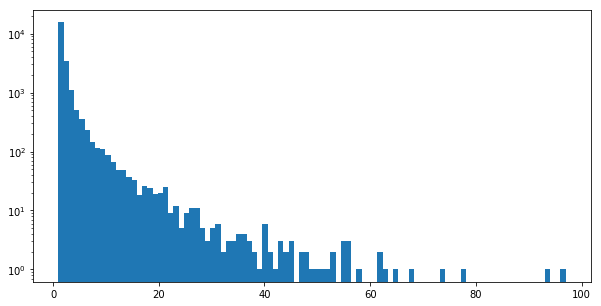

count    22159.000000
mean         2.040390
std          3.645081
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         97.000000
dtype: float64

There are 15530 single-article events and 6629 multiple-article events.


In [41]:
get_infomap_descriptives(H)

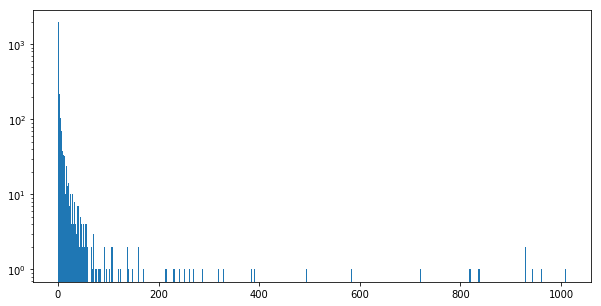

count    3745.000000
mean       12.178371
std        63.519112
min         1.000000
25%         1.000000
50%         1.000000
75%         4.000000
max      1009.000000
dtype: float64

There are 1952 single-article events and 1793 multiple-article events.


In [42]:
get_infomap_descriptives(Hsoft)

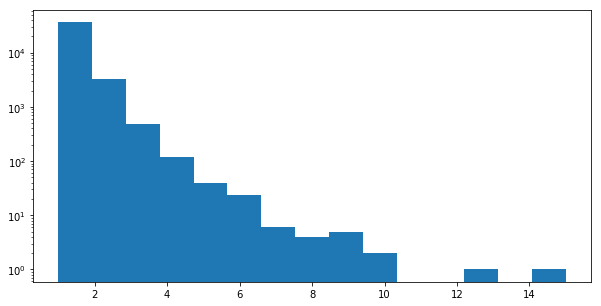

count    40250.000000
mean         1.123304
std          0.447748
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         15.000000
dtype: float64

There are 36349 single-article events and 3901 multiple-article events.


In [43]:
get_infomap_descriptives(H06)

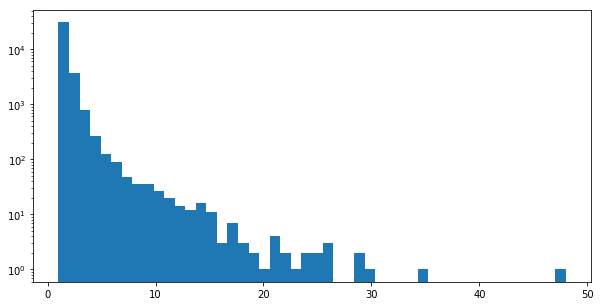

count    35925.000000
mean         1.269534
std          1.134373
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         48.000000
dtype: float64

There are 30700 single-article events and 5225 multiple-article events.


In [44]:
get_infomap_descriptives(Hsoft06)

We see that infomap performs *when used without a threshold* considerably worse than the Leiden algorithms (provided a good threshold): max is too high, mean as well. Large diff between softcosine and cosine.nue
Makes sense though for the "story chains" of Nicholls et al: it's less strict than an event, and it's fine if the story continues with different event.

** if used with threshold, very similar results to our apporach **

# Scratch for further looking into the results of infomap below

## wat we nog zouden kunnen doen: zelfde evaluatie als bij Leiden

In [ ]:
for e in Gnxcos.edges(data=True):
    print(*e)

In [ ]:
G_recoveredlabels = nx.relabel_nodes(Gint, dict(zip(Gint,G)))

In [ ]:
nx.draw(G, with_labels=True)

In [ ]:
H_labeled = nx.relabel_nodes(H, dict(zip(H,G)))

In [ ]:
nx.draw(H_labeled, with_labels=True)

In [ ]:

elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >0.5]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=0.5]

pos=nx.spring_layout(G) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G,pos,node_size=700)

# edges
nx.draw_networkx_edges(G,pos,edgelist=elarge,
                    width=6)
nx.draw_networkx_edges(G,pos,edgelist=esmall,
                    width=6,alpha=0.5,edge_color='b',style='dashed')

# labels
nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')

plt.show()

In [ ]:
G.edges(data=True)